##Nuclei detection with Mask RCNN

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf

from config import Config
import utils
import model as modellib
import visualize
import skimage.color
import skimage.io
from skimage.io import imread, imshow, imread_collection, concatenate_images
from model import log


%matplotlib inline 

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(MODEL_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
#if not os.path.exists(COCO_MODEL_PATH):
#    utils.download_trained_weights(COCO_MODEL_PATH)

D:\Anaconda3\envs\kaggle\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Using TensorFlow backend.


In [3]:
## Define RLE encoding functions
from skimage.morphology import label


def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths


def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)


def mask_encode(masks):
    n_mask = masks.shape[2]
    res = []
    for i in range(n_mask):
        encode_one = prob_to_rles(masks[:, :, i])
        res.extend(encode_one)
    return res

In [4]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [5]:
import matplotlib.patches as patches
from skimage.measure import find_contours
from matplotlib.patches import Polygon


def plot_instances(image, boxes, masks, class_ids, class_names,
                      scores=None, title="",
                      figsize=(16, 16), ax=None):
    """
    boxes: [num_instance, (y1, x1, y2, x2, class_id)] in image coordinates.
    masks: [height, width, num_instances]
    class_ids: [num_instances]
    class_names: list of class names of the dataset
    scores: (optional) confidence scores for each box
    figsize: (optional) the size of the image.
    """
    # Number of instances
    N_box = boxes.shape[0]
    N_mask = masks.shape[2]
    if not N_box:
        print("\n*** No instances to display *** \n")
    #else:
    #    assert boxes.shape[0] == masks.shape[-1] == class_ids.shape[0]

    if not ax:
        _, ax = plt.subplots(1, figsize=figsize)

    # Generate random colors
    colors_box = visualize.random_colors(N_box)
    colors_mask = visualize.random_colors(N_mask)

    # Show area outside image boundaries.
    height, width = image.shape[:2]
    ax.set_ylim(height + 10, -10)
    ax.set_xlim(-10, width + 10)
    ax.axis('off')
    ax.set_title(title)

    masked_image = image.astype(np.uint32).copy()
    for i in range(N_box):
        color = colors_box[i]

        # Bounding box
        if not np.any(boxes[i]):
            # Skip this instance. Has no bbox. Likely lost in image cropping.
            continue
        y1, x1, y2, x2 = boxes[i]
        p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2,
                              alpha=0.7, linestyle="dashed",
                              edgecolor=color, facecolor='none')
        ax.add_patch(p)

        # Label
        class_id = class_ids[i]
        score = scores[i] if scores is not None else None
        label = class_names[class_id]
        x = random.randint(x1, (x1 + x2) // 2)
        caption = "{} {:.3f}".format(label, score) if score else label
        ax.text(x1, y1 + 8, caption,
                color='w', size=11, backgroundcolor="none")
    for i in range(N_mask):
        # Mask
        mask = masks[:, :, i]
        color = colors_mask[i]
        masked_image = visualize.apply_mask(masked_image, mask, color)

        # Mask Polygon
        # Pad to ensure proper polygons for masks that touch image edges.
        padded_mask = np.zeros(
            (mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
        padded_mask[1:-1, 1:-1] = mask
        contours = find_contours(padded_mask, 0.5)
        for verts in contours:
            # Subtract the padding and flip (y, x) to (x, y)
            verts = np.fliplr(verts) - 1
            p = Polygon(verts, facecolor="none", edgecolor=color)
            ax.add_patch(p)
    ax.imshow(masked_image.astype(np.uint8))
    plt.savefig("./plot/" + title + ".png", bbox_inches='tight')
    plt.close()

##Configuration

In [6]:
class NucleiConfig(Config):
    """Configuration for training on the nuclei dataset.
    Derives from the base Config class and overrides values specific
    to the toy nuclei dataset.
    """
    # Give the configuration a recognizable name
    NAME = "nuclei"

    # Train on 1 GPU and 2 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 2 (GPUs * images/GPU).
    # Use the highest number that the GPU/CPU can handel ?
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 1 nuclei class

    # Set the limits of the small side
    # the large side, and that determines the image shape.
    # Image are resized such that the smallest side is >= the min dim 
    # the longest side is <= the max dim
    IMAGE_MIN_DIM = 1024
    IMAGE_MAX_DIM = 1024

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (4, 16, 32, 64, 256)  # anchor side in pixels

    # Number of ROI per image to feed the classifier. The mask RCNN paper 
    # use 512 but often the RPN doesn't generate enough positive proposal
    # to fill this and keep a positive:negative ratio of 1:3.
    # The mean is about 60? choose 200 to keep the positive rate 33%
    TRAIN_ROIS_PER_IMAGE = 200

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
    # Max number of final detection, adjust according to the distribution
    DETECTION_MAX_INSTANCES = 380
    
config = NucleiConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_SHAPES                [[256 256]
 [128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        380
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_MIN_DIM                  1024
IMAGE_PADDING                  True
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           nuclei
NUM_CLASSES                    2
POOL_SIZE                      7
POST_NMS_ROIS_INFERE

## Dataset

Create a nuclei dataset



In [7]:
TRAIN_PATH = './kaggle-dsbowl-2018-dataset-fixes-master/stage1_train/'
TEST_PATH = './input/stage1_test/'
# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]


StopIteration: 

In [8]:
# Augmented image training

batch_name = "AugBatch1"

TRAIN_PATH = './input/' + batch_name + "/"
TEST_PATH = './input/stage1_test/'

# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [9]:
# Function to remove overlapping portion of masks (keep the portion with higher score)
def remove_overlap(masks):
    n_masks = masks.shape[2]

    for i in range(n_masks):
        good_mask = masks[:, :, i]
        for j in range(i + 1, n_masks):
            fix_mask = masks[:, :, j]
            overlapping = (good_mask == 1) & (fix_mask == 1)
            if np.any(overlapping):
                print('Overlapping mask detected!')
                fix_mask[overlapping] = 0
                masks[:, :, j] = fix_mask
    return masks

In [10]:
# create the nuclei dataset
class NucleiDataset(utils.Dataset):
    
    def load_nuclei(self, path, ids):       
        # Add class
        self.add_class("nuclei", 1, "nuclei")

        # Add image
        for i in range(len(ids)):
            path_image = path + ids[i] + '/images/' + ids[i] + '.png'
            mask_path = path + ids[i] + '/masks/'
            self.add_image("nuclei", image_id=i, path=path_image, maskpath=mask_path)
     
    def load_image(self, image_id):
        """Load the specified image and return a [H,W,3] Numpy array.
        """
        # Load image
        image = skimage.io.imread(self.image_info[image_id]['path'])[:, :, :3]
        # If grayscale. Convert to RGB for consistency.
        if image.ndim != 3:
            image = skimage.color.gray2rgb(image)
        return image       
  
    def load_mask(self, i):
        img = self.load_image(i)
        width = img.shape[1]
        height = img.shape[0]
        n = len(next(os.walk(self.image_info[i]['maskpath']))[2])       
        mask = np.zeros((height, width, n), dtype=np.bool)
        for t, mask_file in enumerate(next(os.walk(self.image_info[i]['maskpath']))[2]):            
            mask_ = imread(self.image_info[i]['maskpath'] + mask_file)
            mask[:, :, t:t+1] = np.reshape(mask_,(height,width,1))
        class_ids = np.array([1]*n)
        return mask, class_ids

In [11]:
category = './input/classes.csv'
cate = pd.read_csv(category,index_col=False)
# print((cate['foreground'] == 'white') & (cate['background'] == 'black')) 
white_black = cate.loc[(cate['foreground'] == 'white') \
                       & (cate['background'] == 'black'),'filename'].tolist()
purple_yellow = cate.loc[(cate['foreground'] == 'purple') \
                       & (cate['background'] == 'yellow') ,'filename'].tolist()
purple_white = cate.loc[(cate['foreground'] == 'purple') \
                       & (cate['background'] == 'white') ,'filename'].tolist()
purple_purple = cate.loc[(cate['foreground'] == 'purple') \
                       & (cate['background'] == 'purple') ,'filename'].tolist()
black_white = cate.loc[(cate['foreground'] == 'black') \
                       & (cate['background'] == 'white') ,'filename'].tolist()

print("number of white_black image: %d" %len(white_black))
print("number of purple_yellow image: %d" %len(purple_yellow))
print("number of purple_white image: %d" %len(purple_white))
print("number of purple_purple image: %d" %len(purple_purple))
print("number of black_white image: %d" %len(black_white))


number of white_black image: 599
number of purple_yellow image: 8
number of purple_white image: 41
number of purple_purple image: 71
number of black_white image: 16


In [9]:
print(cate['filename'][1][:-4])

4596961c789d3b41916492918797724fe75128239fefc516c3ee75322b7926f0


In [12]:
train_index = [n for i, n in enumerate(train_ids) \
               if n+".png" in white_black[:int(len(white_black)*0.8)]]
val_index = [n for i, n in enumerate(train_ids) \
             if n+".png" in white_black[int(len(white_black)*0.8):]]
train_index = train_index + [n for i, n in enumerate(train_ids) \
                             if n+".png" in purple_yellow[:int(len(purple_yellow)*0.8)]]
val_index = val_index + [n for i, n in enumerate(train_ids) \
                         if n+".png" in purple_yellow[int(len(purple_yellow)*0.8):]]
train_index = train_index + [n for i, n in enumerate(train_ids) \
                             if n+".png" in purple_white[:int(len(purple_white)*0.8)]]
val_index = val_index + [n for i, n in enumerate(train_ids) \
                         if n+".png" in purple_white[int(len(purple_white)*0.8):]]
train_index = train_index + [n for i, n in enumerate(train_ids) \
                             if n+".png" in purple_purple[:int(len(purple_purple)*0.8)]]
val_index = val_index + [n for i, n in enumerate(train_ids) \
                         if n+".png" in purple_purple[int(len(purple_purple)*0.8):]]
train_index = train_index + [n for i, n in enumerate(train_ids) \
                             if n+".png" in black_white[:int(len(black_white)*0.8)]]
val_index = val_index + [n for i, n in enumerate(train_ids) \
                         if n+".png" in black_white[int(len(black_white)*0.8):]]
print("length of train set: %d" %len(train_index))
print("length of validation set: %d" %len(val_index))
print(bool(set(val_index) & set(train_index)))

length of train set: 531
length of validation set: 133
False


In [14]:
# Training dataset
dataset_train = NucleiDataset()
dataset_train.load_nuclei(TRAIN_PATH, train_index)
dataset_train.prepare()

# Validation dataset
dataset_val = NucleiDataset()
dataset_val.load_nuclei(TRAIN_PATH, val_index) 
dataset_val.prepare()

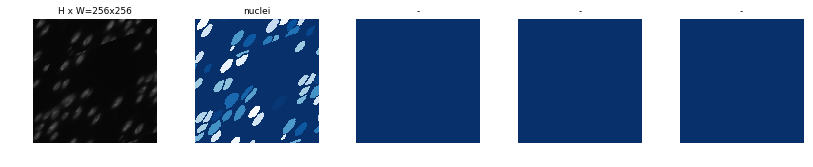

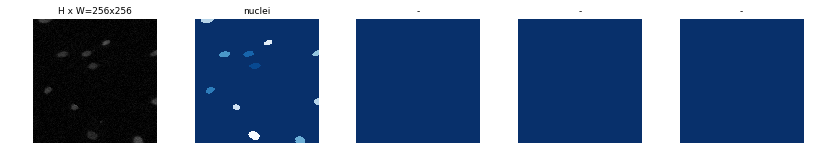

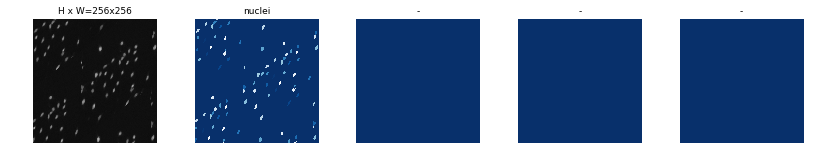

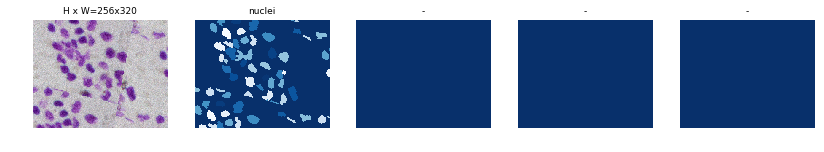

In [15]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)


##Create model

In [16]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [18]:
# Which weights to start with? Used coco weights? 
init_with = "name"  # imagenet, coco, or last
model_name = 'mask_rcnn_shapes_0326_1024pix_enhanced_epoch_all1_3.h5'
if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "name":
    print("loading:",model_name)
    # Load the last model you trained and continue training
    model.load_weights(os.path.join(MODEL_DIR, model_name), by_name=True)


loading: mask_rcnn_shapes_0326_1024pix_enhanced_epoch_all1_3.h5


##Training
Train in two stages:

Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass layers='heads' to the train() function.

Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass layers="all to train all layers.

In [30]:
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=5, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: D:\Kaggle\Kaggle2018\logs\nuclei20180331T1533\mask_rcnn_nuclei_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_

D:\Anaconda3\envs\kaggle\lib\site-packages\tensorflow\python\ops\gradients_impl.py:98: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/5


  1/100 [..............................] - ETA: 13:29 - loss: 2.1679 - rpn_class_loss: 0.0209 - rpn_bbox_loss: 2.1469 - mrcnn_class_loss: 9.8939e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

  2/100 [..............................] - ETA: 9:13 - loss: 2.4635 - rpn_class_loss: 0.0489 - rpn_bbox_loss: 2.0221 - mrcnn_class_loss: 0.1277 - mrcnn_bbox_loss: 0.1241 - mrcnn_mask_loss: 0.1406             

  3/100 [..............................] - ETA: 7:29 - loss: 2.5861 - rpn_class_loss: 0.0615 - rpn_bbox_loss: 2.1063 - mrcnn_class_loss: 0.1110 - mrcnn_bbox_loss: 0.1421 - mrcnn_mask_loss: 0.1652

  4/100 [>.............................] - ETA: 6:31 - loss: 2.5650 - rpn_class_loss: 0.0586 - rpn_bbox_loss: 2.0773 - mrcnn_class_loss: 0.1223 - mrcnn_bbox_loss: 0.1375 - mrcnn_mask_loss: 0.1693

  5/100 [>.............................] - ETA: 6:31 - loss: 2.4260 - rpn_class_loss: 0.0633 - rpn_bbox_loss: 1.8127 - mrcnn_class_loss: 0.1664 - mrcnn_bbox_loss: 0.1778 - mrcnn_mask_loss: 0.2059

  6/100 [>.............................] - ETA: 6:09 - loss: 2.2267 - rpn_class_loss: 0.0582 - rpn_bbox_loss: 1.6198 - mrcnn_class_loss: 0.1625 - mrcnn_bbox_loss: 0.1747 - mrcnn_mask_loss: 0.2116

  7/100 [=>............................] - ETA: 6:14 - loss: 2.3306 - rpn_class_loss: 0.0754 - rpn_bbox_loss: 1.6029 - mrcnn_class_loss: 0.1773 - mrcnn_bbox_loss: 0.2204 - mrcnn_mask_loss: 0.2545

  8/100 [=>............................] - ETA: 5:42 - loss: 2.1923 - rpn_class_loss: 0.0682 - rpn_bbox_loss: 1.4779 - mrcnn_class_loss: 0.1678 - mrcnn_bbox_loss: 0.2244 - mrcnn_mask_loss: 0.2541

  9/100 [=>............................] - ETA: 5:17 - loss: 2.0600 - rpn_class_loss: 0.0616 - rpn_bbox_loss: 1.3640 - mrcnn_class_loss: 0.1584 - mrcnn_bbox_loss: 0.2191 - mrcnn_mask_loss: 0.2570

 10/100 [==>...........................] - ETA: 4:56 - loss: 2.0126 - rpn_class_loss: 0.0589 - rpn_bbox_loss: 1.3551 - mrcnn_class_loss: 0.1451 - mrcnn_bbox_loss: 0.2056 - mrcnn_mask_loss: 0.2479

 11/100 [==>...........................] - ETA: 5:05 - loss: 1.9916 - rpn_class_loss: 0.0622 - rpn_bbox_loss: 1.3310 - mrcnn_class_loss: 0.1635 - mrcnn_bbox_loss: 0.1965 - mrcnn_mask_loss: 0.2385

 12/100 [==>...........................] - ETA: 4:49 - loss: 2.0422 - rpn_class_loss: 0.0639 - rpn_bbox_loss: 1.3803 - mrcnn_class_loss: 0.1552 - mrcnn_bbox_loss: 0.2011 - mrcnn_mask_loss: 0.2418

 13/100 [==>...........................] - ETA: 4:47 - loss: 2.0613 - rpn_class_loss: 0.0632 - rpn_bbox_loss: 1.3699 - mrcnn_class_loss: 0.1654 - mrcnn_bbox_loss: 0.2072 - mrcnn_mask_loss: 0.2557

 14/100 [===>..........................] - ETA: 4:37 - loss: 2.0614 - rpn_class_loss: 0.0616 - rpn_bbox_loss: 1.3649 - mrcnn_class_loss: 0.1606 - mrcnn_bbox_loss: 0.2139 - mrcnn_mask_loss: 0.2604

 15/100 [===>..........................] - ETA: 4:47 - loss: 2.0662 - rpn_class_loss: 0.0658 - rpn_bbox_loss: 1.3532 - mrcnn_class_loss: 0.1736 - mrcnn_bbox_loss: 0.2141 - mrcnn_mask_loss: 0.2593

 16/100 [===>..........................] - ETA: 4:38 - loss: 2.0777 - rpn_class_loss: 0.0664 - rpn_bbox_loss: 1.3322 - mrcnn_class_loss: 0.1903 - mrcnn_bbox_loss: 0.2210 - mrcnn_mask_loss: 0.2677

 17/100 [====>.........................] - ETA: 4:43 - loss: 2.0896 - rpn_class_loss: 0.0726 - rpn_bbox_loss: 1.3278 - mrcnn_class_loss: 0.2018 - mrcnn_bbox_loss: 0.2173 - mrcnn_mask_loss: 0.2701

 18/100 [====>.........................] - ETA: 4:45 - loss: 2.1048 - rpn_class_loss: 0.0745 - rpn_bbox_loss: 1.3359 - mrcnn_class_loss: 0.2103 - mrcnn_bbox_loss: 0.2141 - mrcnn_mask_loss: 0.2701

 19/100 [====>.........................] - ETA: 4:59 - loss: 2.1285 - rpn_class_loss: 0.0814 - rpn_bbox_loss: 1.3457 - mrcnn_class_loss: 0.2136 - mrcnn_bbox_loss: 0.2164 - mrcnn_mask_loss: 0.2714

 20/100 [=====>........................] - ETA: 4:49 - loss: 2.1768 - rpn_class_loss: 0.0788 - rpn_bbox_loss: 1.3852 - mrcnn_class_loss: 0.2061 - mrcnn_bbox_loss: 0.2262 - mrcnn_mask_loss: 0.2805

 21/100 [=====>........................] - ETA: 4:37 - loss: 2.1543 - rpn_class_loss: 0.0776 - rpn_bbox_loss: 1.3853 - mrcnn_class_loss: 0.1975 - mrcnn_bbox_loss: 0.2218 - mrcnn_mask_loss: 0.2721

 22/100 [=====>........................] - ETA: 4:34 - loss: 2.1814 - rpn_class_loss: 0.0811 - rpn_bbox_loss: 1.4030 - mrcnn_class_loss: 0.2028 - mrcnn_bbox_loss: 0.2217 - mrcnn_mask_loss: 0.2728

 23/100 [=====>........................] - ETA: 4:25 - loss: 2.1932 - rpn_class_loss: 0.0792 - rpn_bbox_loss: 1.4103 - mrcnn_class_loss: 0.2040 - mrcnn_bbox_loss: 0.2243 - mrcnn_mask_loss: 0.2755

 24/100 [======>.......................] - ETA: 4:21 - loss: 2.1681 - rpn_class_loss: 0.0798 - rpn_bbox_loss: 1.3884 - mrcnn_class_loss: 0.2062 - mrcnn_bbox_loss: 0.2210 - mrcnn_mask_loss: 0.2727

 25/100 [======>.......................] - ETA: 4:13 - loss: 2.1775 - rpn_class_loss: 0.0785 - rpn_bbox_loss: 1.4088 - mrcnn_class_loss: 0.2034 - mrcnn_bbox_loss: 0.2176 - mrcnn_mask_loss: 0.2692

 26/100 [======>.......................] - ETA: 4:07 - loss: 2.1883 - rpn_class_loss: 0.0772 - rpn_bbox_loss: 1.4204 - mrcnn_class_loss: 0.2061 - mrcnn_bbox_loss: 0.2165 - mrcnn_mask_loss: 0.2681

 27/100 [=======>......................] - ETA: 3:58 - loss: 2.1480 - rpn_class_loss: 0.0744 - rpn_bbox_loss: 1.3794 - mrcnn_class_loss: 0.2052 - mrcnn_bbox_loss: 0.2171 - mrcnn_mask_loss: 0.2720

 28/100 [=======>......................] - ETA: 3:56 - loss: 2.1331 - rpn_class_loss: 0.0742 - rpn_bbox_loss: 1.3612 - mrcnn_class_loss: 0.2067 - mrcnn_bbox_loss: 0.2178 - mrcnn_mask_loss: 0.2732

 29/100 [=======>......................] - ETA: 3:50 - loss: 2.1512 - rpn_class_loss: 0.0740 - rpn_bbox_loss: 1.3918 - mrcnn_class_loss: 0.2007 - mrcnn_bbox_loss: 0.2149 - mrcnn_mask_loss: 0.2699

 30/100 [========>.....................] - ETA: 3:44 - loss: 2.1195 - rpn_class_loss: 0.0725 - rpn_bbox_loss: 1.3698 - mrcnn_class_loss: 0.1987 - mrcnn_bbox_loss: 0.2119 - mrcnn_mask_loss: 0.2666

 31/100 [========>.....................] - ETA: 3:39 - loss: 2.1379 - rpn_class_loss: 0.0719 - rpn_bbox_loss: 1.3997 - mrcnn_class_loss: 0.1933 - mrcnn_bbox_loss: 0.2080 - mrcnn_mask_loss: 0.2650

 32/100 [========>.....................] - ETA: 3:33 - loss: 2.1534 - rpn_class_loss: 0.0730 - rpn_bbox_loss: 1.4091 - mrcnn_class_loss: 0.1950 - mrcnn_bbox_loss: 0.2092 - mrcnn_mask_loss: 0.2670

 33/100 [========>.....................] - ETA: 3:28 - loss: 2.1481 - rpn_class_loss: 0.0748 - rpn_bbox_loss: 1.3918 - mrcnn_class_loss: 0.1992 - mrcnn_bbox_loss: 0.2112 - mrcnn_mask_loss: 0.2711

 34/100 [=========>....................] - ETA: 3:25 - loss: 2.1284 - rpn_class_loss: 0.0740 - rpn_bbox_loss: 1.3770 - mrcnn_class_loss: 0.2001 - mrcnn_bbox_loss: 0.2098 - mrcnn_mask_loss: 0.2674

 35/100 [=========>....................] - ETA: 3:19 - loss: 2.0807 - rpn_class_loss: 0.0720 - rpn_bbox_loss: 1.3437 - mrcnn_class_loss: 0.1954 - mrcnn_bbox_loss: 0.2055 - mrcnn_mask_loss: 0.2641

 36/100 [=========>....................] - ETA: 3:15 - loss: 2.0904 - rpn_class_loss: 0.0743 - rpn_bbox_loss: 1.3484 - mrcnn_class_loss: 0.1931 - mrcnn_bbox_loss: 0.2068 - mrcnn_mask_loss: 0.2677

 37/100 [==========>...................] - ETA: 3:21 - loss: 2.0928 - rpn_class_loss: 0.0781 - rpn_bbox_loss: 1.3371 - mrcnn_class_loss: 0.2012 - mrcnn_bbox_loss: 0.2084 - mrcnn_mask_loss: 0.2679

 38/100 [==========>...................] - ETA: 3:17 - loss: 2.0798 - rpn_class_loss: 0.0789 - rpn_bbox_loss: 1.3256 - mrcnn_class_loss: 0.2015 - mrcnn_bbox_loss: 0.2072 - mrcnn_mask_loss: 0.2667

 39/100 [==========>...................] - ETA: 3:32 - loss: 2.1088 - rpn_class_loss: 0.0867 - rpn_bbox_loss: 1.3358 - mrcnn_class_loss: 0.1966 - mrcnn_bbox_loss: 0.2176 - mrcnn_mask_loss: 0.2721

 40/100 [===========>..................] - ETA: 3:36 - loss: 2.1182 - rpn_class_loss: 0.0884 - rpn_bbox_loss: 1.3282 - mrcnn_class_loss: 0.2005 - mrcnn_bbox_loss: 0.2251 - mrcnn_mask_loss: 0.2761

 41/100 [===========>..................] - ETA: 3:30 - loss: 2.1126 - rpn_class_loss: 0.0878 - rpn_bbox_loss: 1.3274 - mrcnn_class_loss: 0.2007 - mrcnn_bbox_loss: 0.2229 - mrcnn_mask_loss: 0.2738

 42/100 [===========>..................] - ETA: 3:29 - loss: 2.1242 - rpn_class_loss: 0.0905 - rpn_bbox_loss: 1.3308 - mrcnn_class_loss: 0.2050 - mrcnn_bbox_loss: 0.2239 - mrcnn_mask_loss: 0.2740

 43/100 [===========>..................] - ETA: 3:25 - loss: 2.1276 - rpn_class_loss: 0.0919 - rpn_bbox_loss: 1.3327 - mrcnn_class_loss: 0.2072 - mrcnn_bbox_loss: 0.2227 - mrcnn_mask_loss: 0.2730

 44/100 [============>.................] - ETA: 3:21 - loss: 2.1398 - rpn_class_loss: 0.0923 - rpn_bbox_loss: 1.3324 - mrcnn_class_loss: 0.2129 - mrcnn_bbox_loss: 0.2268 - mrcnn_mask_loss: 0.2754

 45/100 [============>.................] - ETA: 3:18 - loss: 2.1462 - rpn_class_loss: 0.0925 - rpn_bbox_loss: 1.3353 - mrcnn_class_loss: 0.2152 - mrcnn_bbox_loss: 0.2281 - mrcnn_mask_loss: 0.2751

 46/100 [============>.................] - ETA: 3:12 - loss: 2.1784 - rpn_class_loss: 0.0916 - rpn_bbox_loss: 1.3704 - mrcnn_class_loss: 0.2152 - mrcnn_bbox_loss: 0.2295 - mrcnn_mask_loss: 0.2715

 47/100 [=============>................] - ETA: 3:07 - loss: 2.1794 - rpn_class_loss: 0.0913 - rpn_bbox_loss: 1.3809 - mrcnn_class_loss: 0.2109 - mrcnn_bbox_loss: 0.2261 - mrcnn_mask_loss: 0.2702

 48/100 [=============>................] - ETA: 3:05 - loss: 2.1738 - rpn_class_loss: 0.0912 - rpn_bbox_loss: 1.3735 - mrcnn_class_loss: 0.2135 - mrcnn_bbox_loss: 0.2256 - mrcnn_mask_loss: 0.2701

 49/100 [=============>................] - ETA: 3:01 - loss: 2.1782 - rpn_class_loss: 0.0902 - rpn_bbox_loss: 1.3826 - mrcnn_class_loss: 0.2125 - mrcnn_bbox_loss: 0.2250 - mrcnn_mask_loss: 0.2679

 50/100 [==============>...............] - ETA: 2:58 - loss: 2.1782 - rpn_class_loss: 0.0904 - rpn_bbox_loss: 1.3758 - mrcnn_class_loss: 0.2169 - mrcnn_bbox_loss: 0.2257 - mrcnn_mask_loss: 0.2693

 51/100 [==============>...............] - ETA: 2:53 - loss: 2.1882 - rpn_class_loss: 0.0894 - rpn_bbox_loss: 1.3819 - mrcnn_class_loss: 0.2176 - mrcnn_bbox_loss: 0.2299 - mrcnn_mask_loss: 0.2694

 52/100 [==============>...............] - ETA: 2:49 - loss: 2.2000 - rpn_class_loss: 0.0890 - rpn_bbox_loss: 1.3863 - mrcnn_class_loss: 0.2224 - mrcnn_bbox_loss: 0.2318 - mrcnn_mask_loss: 0.2706

 53/100 [==============>...............] - ETA: 2:46 - loss: 2.1994 - rpn_class_loss: 0.0888 - rpn_bbox_loss: 1.3833 - mrcnn_class_loss: 0.2251 - mrcnn_bbox_loss: 0.2321 - mrcnn_mask_loss: 0.2700

 54/100 [===============>..............] - ETA: 2:41 - loss: 2.1832 - rpn_class_loss: 0.0874 - rpn_bbox_loss: 1.3729 - mrcnn_class_loss: 0.2247 - mrcnn_bbox_loss: 0.2304 - mrcnn_mask_loss: 0.2678

 55/100 [===============>..............] - ETA: 2:40 - loss: 2.1923 - rpn_class_loss: 0.0873 - rpn_bbox_loss: 1.3683 - mrcnn_class_loss: 0.2306 - mrcnn_bbox_loss: 0.2362 - mrcnn_mask_loss: 0.2698

 56/100 [===============>..............] - ETA: 2:35 - loss: 2.1879 - rpn_class_loss: 0.0862 - rpn_bbox_loss: 1.3717 - mrcnn_class_loss: 0.2302 - mrcnn_bbox_loss: 0.2331 - mrcnn_mask_loss: 0.2667

 57/100 [================>.............] - ETA: 2:31 - loss: 2.2028 - rpn_class_loss: 0.0856 - rpn_bbox_loss: 1.3832 - mrcnn_class_loss: 0.2285 - mrcnn_bbox_loss: 0.2373 - mrcnn_mask_loss: 0.2683

 58/100 [================>.............] - ETA: 2:27 - loss: 2.2038 - rpn_class_loss: 0.0848 - rpn_bbox_loss: 1.3815 - mrcnn_class_loss: 0.2301 - mrcnn_bbox_loss: 0.2383 - mrcnn_mask_loss: 0.2691

 59/100 [================>.............] - ETA: 2:22 - loss: 2.1963 - rpn_class_loss: 0.0836 - rpn_bbox_loss: 1.3798 - mrcnn_class_loss: 0.2295 - mrcnn_bbox_loss: 0.2367 - mrcnn_mask_loss: 0.2667

 60/100 [=================>............] - ETA: 2:17 - loss: 2.1915 - rpn_class_loss: 0.0824 - rpn_bbox_loss: 1.3771 - mrcnn_class_loss: 0.2281 - mrcnn_bbox_loss: 0.2374 - mrcnn_mask_loss: 0.2666

 61/100 [=================>............] - ETA: 2:13 - loss: 2.1780 - rpn_class_loss: 0.0818 - rpn_bbox_loss: 1.3672 - mrcnn_class_loss: 0.2263 - mrcnn_bbox_loss: 0.2376 - mrcnn_mask_loss: 0.2650

 62/100 [=================>............] - ETA: 2:12 - loss: 2.1680 - rpn_class_loss: 0.0817 - rpn_bbox_loss: 1.3586 - mrcnn_class_loss: 0.2291 - mrcnn_bbox_loss: 0.2356 - mrcnn_mask_loss: 0.2629

 63/100 [=================>............] - ETA: 2:08 - loss: 2.1653 - rpn_class_loss: 0.0810 - rpn_bbox_loss: 1.3539 - mrcnn_class_loss: 0.2304 - mrcnn_bbox_loss: 0.2365 - mrcnn_mask_loss: 0.2635

 64/100 [==================>...........] - ETA: 2:04 - loss: 2.1835 - rpn_class_loss: 0.0816 - rpn_bbox_loss: 1.3590 - mrcnn_class_loss: 0.2327 - mrcnn_bbox_loss: 0.2397 - mrcnn_mask_loss: 0.2704

 65/100 [==================>...........] - ETA: 2:00 - loss: 2.1911 - rpn_class_loss: 0.0808 - rpn_bbox_loss: 1.3623 - mrcnn_class_loss: 0.2334 - mrcnn_bbox_loss: 0.2451 - mrcnn_mask_loss: 0.2696

 66/100 [==================>...........] - ETA: 1:56 - loss: 2.1935 - rpn_class_loss: 0.0802 - rpn_bbox_loss: 1.3588 - mrcnn_class_loss: 0.2340 - mrcnn_bbox_loss: 0.2492 - mrcnn_mask_loss: 0.2714

 67/100 [===================>..........] - ETA: 1:53 - loss: 2.1944 - rpn_class_loss: 0.0805 - rpn_bbox_loss: 1.3545 - mrcnn_class_loss: 0.2378 - mrcnn_bbox_loss: 0.2500 - mrcnn_mask_loss: 0.2717

 68/100 [===================>..........] - ETA: 1:48 - loss: 2.1841 - rpn_class_loss: 0.0793 - rpn_bbox_loss: 1.3411 - mrcnn_class_loss: 0.2348 - mrcnn_bbox_loss: 0.2519 - mrcnn_mask_loss: 0.2771

 69/100 [===================>..........] - ETA: 1:44 - loss: 2.1713 - rpn_class_loss: 0.0787 - rpn_bbox_loss: 1.3339 - mrcnn_class_loss: 0.2334 - mrcnn_bbox_loss: 0.2504 - mrcnn_mask_loss: 0.2748

 70/100 [====================>.........] - ETA: 1:43 - loss: 2.1629 - rpn_class_loss: 0.0800 - rpn_bbox_loss: 1.3260 - mrcnn_class_loss: 0.2347 - mrcnn_bbox_loss: 0.2488 - mrcnn_mask_loss: 0.2734

 71/100 [====================>.........] - ETA: 1:39 - loss: 2.1639 - rpn_class_loss: 0.0798 - rpn_bbox_loss: 1.3221 - mrcnn_class_loss: 0.2360 - mrcnn_bbox_loss: 0.2522 - mrcnn_mask_loss: 0.2737

 72/100 [====================>.........] - ETA: 1:35 - loss: 2.1454 - rpn_class_loss: 0.0788 - rpn_bbox_loss: 1.3086 - mrcnn_class_loss: 0.2353 - mrcnn_bbox_loss: 0.2503 - mrcnn_mask_loss: 0.2724

 73/100 [====================>.........] - ETA: 1:31 - loss: 2.1349 - rpn_class_loss: 0.0783 - rpn_bbox_loss: 1.3032 - mrcnn_class_loss: 0.2346 - mrcnn_bbox_loss: 0.2480 - mrcnn_mask_loss: 0.2709

 74/100 [=====================>........] - ETA: 1:27 - loss: 2.1243 - rpn_class_loss: 0.0778 - rpn_bbox_loss: 1.2903 - mrcnn_class_loss: 0.2360 - mrcnn_bbox_loss: 0.2481 - mrcnn_mask_loss: 0.2721

 75/100 [=====================>........] - ETA: 1:24 - loss: 2.1217 - rpn_class_loss: 0.0773 - rpn_bbox_loss: 1.2873 - mrcnn_class_loss: 0.2369 - mrcnn_bbox_loss: 0.2490 - mrcnn_mask_loss: 0.2712

 76/100 [=====================>........] - ETA: 1:20 - loss: 2.1349 - rpn_class_loss: 0.0769 - rpn_bbox_loss: 1.2859 - mrcnn_class_loss: 0.2368 - mrcnn_bbox_loss: 0.2548 - mrcnn_mask_loss: 0.2804

 77/100 [======================>.......] - ETA: 1:17 - loss: 2.1232 - rpn_class_loss: 0.0769 - rpn_bbox_loss: 1.2770 - mrcnn_class_loss: 0.2376 - mrcnn_bbox_loss: 0.2527 - mrcnn_mask_loss: 0.2791

 78/100 [======================>.......] - ETA: 1:16 - loss: 2.1149 - rpn_class_loss: 0.0783 - rpn_bbox_loss: 1.2685 - mrcnn_class_loss: 0.2384 - mrcnn_bbox_loss: 0.2513 - mrcnn_mask_loss: 0.2784

 79/100 [======================>.......] - ETA: 1:13 - loss: 2.1109 - rpn_class_loss: 0.0780 - rpn_bbox_loss: 1.2665 - mrcnn_class_loss: 0.2387 - mrcnn_bbox_loss: 0.2501 - mrcnn_mask_loss: 0.2776

 80/100 [=======================>......] - ETA: 1:10 - loss: 2.1047 - rpn_class_loss: 0.0780 - rpn_bbox_loss: 1.2628 - mrcnn_class_loss: 0.2396 - mrcnn_bbox_loss: 0.2481 - mrcnn_mask_loss: 0.2763

 81/100 [=======================>......] - ETA: 1:06 - loss: 2.1037 - rpn_class_loss: 0.0781 - rpn_bbox_loss: 1.2647 - mrcnn_class_loss: 0.2379 - mrcnn_bbox_loss: 0.2475 - mrcnn_mask_loss: 0.2755

 82/100 [=======================>......] - ETA: 1:02 - loss: 2.1285 - rpn_class_loss: 0.0789 - rpn_bbox_loss: 1.2742 - mrcnn_class_loss: 0.2463 - mrcnn_bbox_loss: 0.2513 - mrcnn_mask_loss: 0.2779

 83/100 [=======================>......] - ETA: 58s - loss: 2.1268 - rpn_class_loss: 0.0784 - rpn_bbox_loss: 1.2779 - mrcnn_class_loss: 0.2447 - mrcnn_bbox_loss: 0.2492 - mrcnn_mask_loss: 0.2767 

 84/100 [========================>.....] - ETA: 55s - loss: 2.1336 - rpn_class_loss: 0.0783 - rpn_bbox_loss: 1.2832 - mrcnn_class_loss: 0.2455 - mrcnn_bbox_loss: 0.2497 - mrcnn_mask_loss: 0.2769

 85/100 [========================>.....] - ETA: 51s - loss: 2.1427 - rpn_class_loss: 0.0787 - rpn_bbox_loss: 1.2956 - mrcnn_class_loss: 0.2443 - mrcnn_bbox_loss: 0.2482 - mrcnn_mask_loss: 0.2759

 86/100 [========================>.....] - ETA: 48s - loss: 2.1463 - rpn_class_loss: 0.0785 - rpn_bbox_loss: 1.3006 - mrcnn_class_loss: 0.2426 - mrcnn_bbox_loss: 0.2488 - mrcnn_mask_loss: 0.2758

 87/100 [=========================>....] - ETA: 44s - loss: 2.1489 - rpn_class_loss: 0.0779 - rpn_bbox_loss: 1.3062 - mrcnn_class_loss: 0.2420 - mrcnn_bbox_loss: 0.2480 - mrcnn_mask_loss: 0.2747

 88/100 [=========================>....] - ETA: 41s - loss: 2.1442 - rpn_class_loss: 0.0778 - rpn_bbox_loss: 1.3017 - mrcnn_class_loss: 0.2427 - mrcnn_bbox_loss: 0.2477 - mrcnn_mask_loss: 0.2743

 89/100 [=========================>....] - ETA: 37s - loss: 2.1432 - rpn_class_loss: 0.0773 - rpn_bbox_loss: 1.3016 - mrcnn_class_loss: 0.2425 - mrcnn_bbox_loss: 0.2474 - mrcnn_mask_loss: 0.2743

 90/100 [==========================>...] - ETA: 34s - loss: 2.1354 - rpn_class_loss: 0.0768 - rpn_bbox_loss: 1.2970 - mrcnn_class_loss: 0.2421 - mrcnn_bbox_loss: 0.2461 - mrcnn_mask_loss: 0.2735

 91/100 [==========================>...] - ETA: 30s - loss: 2.1344 - rpn_class_loss: 0.0771 - rpn_bbox_loss: 1.2951 - mrcnn_class_loss: 0.2426 - mrcnn_bbox_loss: 0.2463 - mrcnn_mask_loss: 0.2734

 92/100 [==========================>...] - ETA: 27s - loss: 2.1311 - rpn_class_loss: 0.0765 - rpn_bbox_loss: 1.2933 - mrcnn_class_loss: 0.2419 - mrcnn_bbox_loss: 0.2464 - mrcnn_mask_loss: 0.2731

 93/100 [==========================>...] - ETA: 23s - loss: 2.1278 - rpn_class_loss: 0.0763 - rpn_bbox_loss: 1.2893 - mrcnn_class_loss: 0.2425 - mrcnn_bbox_loss: 0.2463 - mrcnn_mask_loss: 0.2734

 94/100 [===========================>..] - ETA: 20s - loss: 2.1135 - rpn_class_loss: 0.0758 - rpn_bbox_loss: 1.2803 - mrcnn_class_loss: 0.2416 - mrcnn_bbox_loss: 0.2441 - mrcnn_mask_loss: 0.2717

 95/100 [===========================>..] - ETA: 16s - loss: 2.1164 - rpn_class_loss: 0.0760 - rpn_bbox_loss: 1.2805 - mrcnn_class_loss: 0.2407 - mrcnn_bbox_loss: 0.2455 - mrcnn_mask_loss: 0.2737

 96/100 [===========================>..] - ETA: 13s - loss: 2.1103 - rpn_class_loss: 0.0758 - rpn_bbox_loss: 1.2746 - mrcnn_class_loss: 0.2412 - mrcnn_bbox_loss: 0.2448 - mrcnn_mask_loss: 0.2739

 97/100 [============================>.] - ETA: 10s - loss: 2.1146 - rpn_class_loss: 0.0754 - rpn_bbox_loss: 1.2786 - mrcnn_class_loss: 0.2393 - mrcnn_bbox_loss: 0.2459 - mrcnn_mask_loss: 0.2755

 98/100 [============================>.] - ETA: 6s - loss: 2.1204 - rpn_class_loss: 0.0751 - rpn_bbox_loss: 1.2824 - mrcnn_class_loss: 0.2385 - mrcnn_bbox_loss: 0.2501 - mrcnn_mask_loss: 0.2744 

 99/100 [============================>.] - ETA: 3s - loss: 2.1107 - rpn_class_loss: 0.0746 - rpn_bbox_loss: 1.2764 - mrcnn_class_loss: 0.2373 - mrcnn_bbox_loss: 0.2488 - mrcnn_mask_loss: 0.2735

100/100 [==============================] - 343s 3s/step - loss: 2.1039 - rpn_class_loss: 0.0757 - rpn_bbox_loss: 1.2713 - mrcnn_class_loss: 0.2377 - mrcnn_bbox_loss: 0.2470 - mrcnn_mask_loss: 0.2722 - val_loss: 2.1128 - val_rpn_class_loss: 0.0269 - val_rpn_bbox_loss: 1.7635 - val_mrcnn_class_loss: 0.0607 - val_mrcnn_bbox_loss: 0.1469 - val_mrcnn_mask_loss: 0.1147


Epoch 2/5


  1/100 [..............................] - ETA: 3:23 - loss: 2.2213 - rpn_class_loss: 0.0424 - rpn_bbox_loss: 1.2021 - mrcnn_class_loss: 0.3295 - mrcnn_bbox_loss: 0.4315 - mrcnn_mask_loss: 0.2158

  2/100 [..............................] - ETA: 3:47 - loss: 2.0723 - rpn_class_loss: 0.0323 - rpn_bbox_loss: 1.2399 - mrcnn_class_loss: 0.2681 - mrcnn_bbox_loss: 0.3203 - mrcnn_mask_loss: 0.2116

  3/100 [..............................] - ETA: 3:25 - loss: 2.0074 - rpn_class_loss: 0.0273 - rpn_bbox_loss: 1.2799 - mrcnn_class_loss: 0.2529 - mrcnn_bbox_loss: 0.2706 - mrcnn_mask_loss: 0.1768

  4/100 [>.............................] - ETA: 4:13 - loss: 1.9748 - rpn_class_loss: 0.0378 - rpn_bbox_loss: 1.2233 - mrcnn_class_loss: 0.2732 - mrcnn_bbox_loss: 0.2493 - mrcnn_mask_loss: 0.1912

  5/100 [>.............................] - ETA: 4:24 - loss: 1.9985 - rpn_class_loss: 0.0375 - rpn_bbox_loss: 1.2220 - mrcnn_class_loss: 0.2717 - mrcnn_bbox_loss: 0.2732 - mrcnn_mask_loss: 0.1941

  6/100 [>.............................] - ETA: 4:09 - loss: 2.0750 - rpn_class_loss: 0.0381 - rpn_bbox_loss: 1.2476 - mrcnn_class_loss: 0.2782 - mrcnn_bbox_loss: 0.3028 - mrcnn_mask_loss: 0.2084

  7/100 [=>............................] - ETA: 3:59 - loss: 2.0579 - rpn_class_loss: 0.0374 - rpn_bbox_loss: 1.1744 - mrcnn_class_loss: 0.2786 - mrcnn_bbox_loss: 0.3177 - mrcnn_mask_loss: 0.2498

  8/100 [=>............................] - ETA: 4:06 - loss: 2.0639 - rpn_class_loss: 0.0494 - rpn_bbox_loss: 1.1594 - mrcnn_class_loss: 0.2946 - mrcnn_bbox_loss: 0.3152 - mrcnn_mask_loss: 0.2453

  9/100 [=>............................] - ETA: 4:00 - loss: 2.0499 - rpn_class_loss: 0.0493 - rpn_bbox_loss: 1.1620 - mrcnn_class_loss: 0.2860 - mrcnn_bbox_loss: 0.3102 - mrcnn_mask_loss: 0.2424

 10/100 [==>...........................] - ETA: 5:24 - loss: 2.0503 - rpn_class_loss: 0.0690 - rpn_bbox_loss: 1.2265 - mrcnn_class_loss: 0.2575 - mrcnn_bbox_loss: 0.2792 - mrcnn_mask_loss: 0.2182

 11/100 [==>...........................] - ETA: 5:30 - loss: 2.0285 - rpn_class_loss: 0.0655 - rpn_bbox_loss: 1.2114 - mrcnn_class_loss: 0.2584 - mrcnn_bbox_loss: 0.2749 - mrcnn_mask_loss: 0.2183

 12/100 [==>...........................] - ETA: 5:12 - loss: 2.0965 - rpn_class_loss: 0.0646 - rpn_bbox_loss: 1.2613 - mrcnn_class_loss: 0.2512 - mrcnn_bbox_loss: 0.2922 - mrcnn_mask_loss: 0.2272

 13/100 [==>...........................] - ETA: 5:01 - loss: 2.0494 - rpn_class_loss: 0.0642 - rpn_bbox_loss: 1.2172 - mrcnn_class_loss: 0.2500 - mrcnn_bbox_loss: 0.2866 - mrcnn_mask_loss: 0.2313

 14/100 [===>..........................] - ETA: 4:57 - loss: 2.0383 - rpn_class_loss: 0.0644 - rpn_bbox_loss: 1.2047 - mrcnn_class_loss: 0.2540 - mrcnn_bbox_loss: 0.2811 - mrcnn_mask_loss: 0.2341

 15/100 [===>..........................] - ETA: 4:42 - loss: 2.0093 - rpn_class_loss: 0.0620 - rpn_bbox_loss: 1.2079 - mrcnn_class_loss: 0.2474 - mrcnn_bbox_loss: 0.2660 - mrcnn_mask_loss: 0.2260

 16/100 [===>..........................] - ETA: 4:52 - loss: 2.0535 - rpn_class_loss: 0.0687 - rpn_bbox_loss: 1.2337 - mrcnn_class_loss: 0.2535 - mrcnn_bbox_loss: 0.2724 - mrcnn_mask_loss: 0.2252

 17/100 [====>.........................] - ETA: 4:42 - loss: 2.0756 - rpn_class_loss: 0.0659 - rpn_bbox_loss: 1.2663 - mrcnn_class_loss: 0.2405 - mrcnn_bbox_loss: 0.2878 - mrcnn_mask_loss: 0.2151

 18/100 [====>.........................] - ETA: 4:31 - loss: 2.0823 - rpn_class_loss: 0.0634 - rpn_bbox_loss: 1.2811 - mrcnn_class_loss: 0.2396 - mrcnn_bbox_loss: 0.2837 - mrcnn_mask_loss: 0.2147

 19/100 [====>.........................] - ETA: 4:28 - loss: 2.0604 - rpn_class_loss: 0.0636 - rpn_bbox_loss: 1.2630 - mrcnn_class_loss: 0.2407 - mrcnn_bbox_loss: 0.2772 - mrcnn_mask_loss: 0.2159

 20/100 [=====>........................] - ETA: 4:22 - loss: 2.0871 - rpn_class_loss: 0.0661 - rpn_bbox_loss: 1.2878 - mrcnn_class_loss: 0.2343 - mrcnn_bbox_loss: 0.2843 - mrcnn_mask_loss: 0.2146

 21/100 [=====>........................] - ETA: 4:22 - loss: 2.1039 - rpn_class_loss: 0.0645 - rpn_bbox_loss: 1.2828 - mrcnn_class_loss: 0.2410 - mrcnn_bbox_loss: 0.2990 - mrcnn_mask_loss: 0.2165

 22/100 [=====>........................] - ETA: 4:15 - loss: 2.0727 - rpn_class_loss: 0.0642 - rpn_bbox_loss: 1.2595 - mrcnn_class_loss: 0.2412 - mrcnn_bbox_loss: 0.2927 - mrcnn_mask_loss: 0.2150

 23/100 [=====>........................] - ETA: 4:07 - loss: 2.0542 - rpn_class_loss: 0.0624 - rpn_bbox_loss: 1.2529 - mrcnn_class_loss: 0.2338 - mrcnn_bbox_loss: 0.2958 - mrcnn_mask_loss: 0.2094

 24/100 [======>.......................] - ETA: 4:00 - loss: 2.0325 - rpn_class_loss: 0.0621 - rpn_bbox_loss: 1.2396 - mrcnn_class_loss: 0.2312 - mrcnn_bbox_loss: 0.2902 - mrcnn_mask_loss: 0.2094

 25/100 [======>.......................] - ETA: 3:54 - loss: 2.0531 - rpn_class_loss: 0.0619 - rpn_bbox_loss: 1.2342 - mrcnn_class_loss: 0.2351 - mrcnn_bbox_loss: 0.3020 - mrcnn_mask_loss: 0.2198

 26/100 [======>.......................] - ETA: 3:50 - loss: 2.0549 - rpn_class_loss: 0.0635 - rpn_bbox_loss: 1.2242 - mrcnn_class_loss: 0.2386 - mrcnn_bbox_loss: 0.3040 - mrcnn_mask_loss: 0.2247

 27/100 [=======>......................] - ETA: 3:45 - loss: 2.0460 - rpn_class_loss: 0.0638 - rpn_bbox_loss: 1.2218 - mrcnn_class_loss: 0.2328 - mrcnn_bbox_loss: 0.3076 - mrcnn_mask_loss: 0.2200

 28/100 [=======>......................] - ETA: 3:38 - loss: 2.0085 - rpn_class_loss: 0.0634 - rpn_bbox_loss: 1.1967 - mrcnn_class_loss: 0.2297 - mrcnn_bbox_loss: 0.2998 - mrcnn_mask_loss: 0.2189

 29/100 [=======>......................] - ETA: 3:34 - loss: 1.9826 - rpn_class_loss: 0.0619 - rpn_bbox_loss: 1.1803 - mrcnn_class_loss: 0.2287 - mrcnn_bbox_loss: 0.2931 - mrcnn_mask_loss: 0.2187

 30/100 [========>.....................] - ETA: 3:27 - loss: 1.9643 - rpn_class_loss: 0.0602 - rpn_bbox_loss: 1.1763 - mrcnn_class_loss: 0.2230 - mrcnn_bbox_loss: 0.2865 - mrcnn_mask_loss: 0.2184

 31/100 [========>.....................] - ETA: 3:23 - loss: 1.9520 - rpn_class_loss: 0.0591 - rpn_bbox_loss: 1.1772 - mrcnn_class_loss: 0.2208 - mrcnn_bbox_loss: 0.2798 - mrcnn_mask_loss: 0.2151

 32/100 [========>.....................] - ETA: 3:21 - loss: 1.9828 - rpn_class_loss: 0.0591 - rpn_bbox_loss: 1.1839 - mrcnn_class_loss: 0.2318 - mrcnn_bbox_loss: 0.2854 - mrcnn_mask_loss: 0.2227

 33/100 [========>.....................] - ETA: 3:15 - loss: 2.0099 - rpn_class_loss: 0.0583 - rpn_bbox_loss: 1.2133 - mrcnn_class_loss: 0.2270 - mrcnn_bbox_loss: 0.2940 - mrcnn_mask_loss: 0.2172

 34/100 [=========>....................] - ETA: 3:15 - loss: 2.0229 - rpn_class_loss: 0.0587 - rpn_bbox_loss: 1.2068 - mrcnn_class_loss: 0.2367 - mrcnn_bbox_loss: 0.3021 - mrcnn_mask_loss: 0.2187

 35/100 [=========>....................] - ETA: 3:09 - loss: 1.9959 - rpn_class_loss: 0.0575 - rpn_bbox_loss: 1.1906 - mrcnn_class_loss: 0.2331 - mrcnn_bbox_loss: 0.2977 - mrcnn_mask_loss: 0.2170

 36/100 [=========>....................] - ETA: 3:18 - loss: 1.9951 - rpn_class_loss: 0.0580 - rpn_bbox_loss: 1.1839 - mrcnn_class_loss: 0.2382 - mrcnn_bbox_loss: 0.2970 - mrcnn_mask_loss: 0.2179

 37/100 [==========>...................] - ETA: 3:12 - loss: 2.0129 - rpn_class_loss: 0.0570 - rpn_bbox_loss: 1.2028 - mrcnn_class_loss: 0.2337 - mrcnn_bbox_loss: 0.2991 - mrcnn_mask_loss: 0.2204

 38/100 [==========>...................] - ETA: 3:09 - loss: 2.0108 - rpn_class_loss: 0.0565 - rpn_bbox_loss: 1.2017 - mrcnn_class_loss: 0.2339 - mrcnn_bbox_loss: 0.2977 - mrcnn_mask_loss: 0.2210

 39/100 [==========>...................] - ETA: 3:04 - loss: 1.9985 - rpn_class_loss: 0.0558 - rpn_bbox_loss: 1.1995 - mrcnn_class_loss: 0.2317 - mrcnn_bbox_loss: 0.2934 - mrcnn_mask_loss: 0.2182

 40/100 [===========>..................] - ETA: 3:01 - loss: 1.9983 - rpn_class_loss: 0.0552 - rpn_bbox_loss: 1.1930 - mrcnn_class_loss: 0.2341 - mrcnn_bbox_loss: 0.2977 - mrcnn_mask_loss: 0.2183

 41/100 [===========>..................] - ETA: 2:58 - loss: 2.0003 - rpn_class_loss: 0.0549 - rpn_bbox_loss: 1.1946 - mrcnn_class_loss: 0.2345 - mrcnn_bbox_loss: 0.2964 - mrcnn_mask_loss: 0.2198

 42/100 [===========>..................] - ETA: 2:52 - loss: 1.9844 - rpn_class_loss: 0.0538 - rpn_bbox_loss: 1.1863 - mrcnn_class_loss: 0.2299 - mrcnn_bbox_loss: 0.2993 - mrcnn_mask_loss: 0.2151

 43/100 [===========>..................] - ETA: 2:51 - loss: 1.9928 - rpn_class_loss: 0.0551 - rpn_bbox_loss: 1.1966 - mrcnn_class_loss: 0.2278 - mrcnn_bbox_loss: 0.2992 - mrcnn_mask_loss: 0.2142

 44/100 [============>.................] - ETA: 2:49 - loss: 2.0029 - rpn_class_loss: 0.0548 - rpn_bbox_loss: 1.2036 - mrcnn_class_loss: 0.2280 - mrcnn_bbox_loss: 0.3007 - mrcnn_mask_loss: 0.2157

 45/100 [============>.................] - ETA: 2:47 - loss: 2.0166 - rpn_class_loss: 0.0552 - rpn_bbox_loss: 1.2013 - mrcnn_class_loss: 0.2351 - mrcnn_bbox_loss: 0.3037 - mrcnn_mask_loss: 0.2212

 46/100 [============>.................] - ETA: 2:49 - loss: 2.0215 - rpn_class_loss: 0.0560 - rpn_bbox_loss: 1.1931 - mrcnn_class_loss: 0.2409 - mrcnn_bbox_loss: 0.3064 - mrcnn_mask_loss: 0.2250

 47/100 [=============>................] - ETA: 2:54 - loss: 2.0439 - rpn_class_loss: 0.0615 - rpn_bbox_loss: 1.2072 - mrcnn_class_loss: 0.2400 - mrcnn_bbox_loss: 0.3089 - mrcnn_mask_loss: 0.2264

 48/100 [=============>................] - ETA: 2:49 - loss: 2.0463 - rpn_class_loss: 0.0611 - rpn_bbox_loss: 1.2081 - mrcnn_class_loss: 0.2378 - mrcnn_bbox_loss: 0.3102 - mrcnn_mask_loss: 0.2292

 49/100 [=============>................] - ETA: 2:45 - loss: 2.0437 - rpn_class_loss: 0.0603 - rpn_bbox_loss: 1.2045 - mrcnn_class_loss: 0.2379 - mrcnn_bbox_loss: 0.3117 - mrcnn_mask_loss: 0.2292

 50/100 [==============>...............] - ETA: 2:41 - loss: 2.0692 - rpn_class_loss: 0.0603 - rpn_bbox_loss: 1.2195 - mrcnn_class_loss: 0.2366 - mrcnn_bbox_loss: 0.3233 - mrcnn_mask_loss: 0.2296

 51/100 [==============>...............] - ETA: 2:37 - loss: 2.0633 - rpn_class_loss: 0.0597 - rpn_bbox_loss: 1.2091 - mrcnn_class_loss: 0.2358 - mrcnn_bbox_loss: 0.3249 - mrcnn_mask_loss: 0.2337

 52/100 [==============>...............] - ETA: 2:33 - loss: 2.0481 - rpn_class_loss: 0.0592 - rpn_bbox_loss: 1.1995 - mrcnn_class_loss: 0.2345 - mrcnn_bbox_loss: 0.3227 - mrcnn_mask_loss: 0.2323

 53/100 [==============>...............] - ETA: 2:29 - loss: 2.0445 - rpn_class_loss: 0.0590 - rpn_bbox_loss: 1.1939 - mrcnn_class_loss: 0.2352 - mrcnn_bbox_loss: 0.3242 - mrcnn_mask_loss: 0.2322

 54/100 [===============>..............] - ETA: 2:26 - loss: 2.0506 - rpn_class_loss: 0.0591 - rpn_bbox_loss: 1.1931 - mrcnn_class_loss: 0.2356 - mrcnn_bbox_loss: 0.3264 - mrcnn_mask_loss: 0.2365

 55/100 [===============>..............] - ETA: 2:21 - loss: 2.0437 - rpn_class_loss: 0.0592 - rpn_bbox_loss: 1.1880 - mrcnn_class_loss: 0.2337 - mrcnn_bbox_loss: 0.3250 - mrcnn_mask_loss: 0.2377

 56/100 [===============>..............] - ETA: 2:17 - loss: 2.0452 - rpn_class_loss: 0.0588 - rpn_bbox_loss: 1.1953 - mrcnn_class_loss: 0.2328 - mrcnn_bbox_loss: 0.3230 - mrcnn_mask_loss: 0.2354

 57/100 [================>.............] - ETA: 2:25 - loss: 2.0568 - rpn_class_loss: 0.0631 - rpn_bbox_loss: 1.1964 - mrcnn_class_loss: 0.2337 - mrcnn_bbox_loss: 0.3251 - mrcnn_mask_loss: 0.2385

 58/100 [================>.............] - ETA: 2:20 - loss: 2.0338 - rpn_class_loss: 0.0626 - rpn_bbox_loss: 1.1828 - mrcnn_class_loss: 0.2305 - mrcnn_bbox_loss: 0.3211 - mrcnn_mask_loss: 0.2368

 59/100 [================>.............] - ETA: 2:15 - loss: 2.0172 - rpn_class_loss: 0.0618 - rpn_bbox_loss: 1.1726 - mrcnn_class_loss: 0.2282 - mrcnn_bbox_loss: 0.3178 - mrcnn_mask_loss: 0.2367

 60/100 [=================>............] - ETA: 2:11 - loss: 2.0140 - rpn_class_loss: 0.0615 - rpn_bbox_loss: 1.1725 - mrcnn_class_loss: 0.2275 - mrcnn_bbox_loss: 0.3176 - mrcnn_mask_loss: 0.2350

 61/100 [=================>............] - ETA: 2:07 - loss: 2.0171 - rpn_class_loss: 0.0625 - rpn_bbox_loss: 1.1727 - mrcnn_class_loss: 0.2286 - mrcnn_bbox_loss: 0.3181 - mrcnn_mask_loss: 0.2352

 62/100 [=================>............] - ETA: 2:03 - loss: 2.0110 - rpn_class_loss: 0.0618 - rpn_bbox_loss: 1.1705 - mrcnn_class_loss: 0.2264 - mrcnn_bbox_loss: 0.3192 - mrcnn_mask_loss: 0.2330

 63/100 [=================>............] - ETA: 2:01 - loss: 2.0212 - rpn_class_loss: 0.0619 - rpn_bbox_loss: 1.1737 - mrcnn_class_loss: 0.2296 - mrcnn_bbox_loss: 0.3211 - mrcnn_mask_loss: 0.2349

 64/100 [==================>...........] - ETA: 1:58 - loss: 2.0202 - rpn_class_loss: 0.0623 - rpn_bbox_loss: 1.1687 - mrcnn_class_loss: 0.2306 - mrcnn_bbox_loss: 0.3217 - mrcnn_mask_loss: 0.2369

 65/100 [==================>...........] - ETA: 1:54 - loss: 2.0136 - rpn_class_loss: 0.0622 - rpn_bbox_loss: 1.1633 - mrcnn_class_loss: 0.2313 - mrcnn_bbox_loss: 0.3205 - mrcnn_mask_loss: 0.2364

 66/100 [==================>...........] - ETA: 1:53 - loss: 2.0193 - rpn_class_loss: 0.0627 - rpn_bbox_loss: 1.1647 - mrcnn_class_loss: 0.2332 - mrcnn_bbox_loss: 0.3220 - mrcnn_mask_loss: 0.2367

 67/100 [===================>..........] - ETA: 1:49 - loss: 2.0280 - rpn_class_loss: 0.0623 - rpn_bbox_loss: 1.1683 - mrcnn_class_loss: 0.2322 - mrcnn_bbox_loss: 0.3286 - mrcnn_mask_loss: 0.2366

 68/100 [===================>..........] - ETA: 1:48 - loss: 2.0327 - rpn_class_loss: 0.0655 - rpn_bbox_loss: 1.1689 - mrcnn_class_loss: 0.2324 - mrcnn_bbox_loss: 0.3297 - mrcnn_mask_loss: 0.2362

 69/100 [===================>..........] - ETA: 1:48 - loss: 2.0461 - rpn_class_loss: 0.0693 - rpn_bbox_loss: 1.1682 - mrcnn_class_loss: 0.2327 - mrcnn_bbox_loss: 0.3366 - mrcnn_mask_loss: 0.2394

 70/100 [====================>.........] - ETA: 1:47 - loss: 2.0382 - rpn_class_loss: 0.0695 - rpn_bbox_loss: 1.1630 - mrcnn_class_loss: 0.2331 - mrcnn_bbox_loss: 0.3341 - mrcnn_mask_loss: 0.2385

 71/100 [====================>.........] - ETA: 1:44 - loss: 2.0320 - rpn_class_loss: 0.0701 - rpn_bbox_loss: 1.1563 - mrcnn_class_loss: 0.2341 - mrcnn_bbox_loss: 0.3338 - mrcnn_mask_loss: 0.2377

 72/100 [====================>.........] - ETA: 1:41 - loss: 2.0308 - rpn_class_loss: 0.0700 - rpn_bbox_loss: 1.1540 - mrcnn_class_loss: 0.2366 - mrcnn_bbox_loss: 0.3323 - mrcnn_mask_loss: 0.2379

 73/100 [====================>.........] - ETA: 1:37 - loss: 2.0285 - rpn_class_loss: 0.0705 - rpn_bbox_loss: 1.1480 - mrcnn_class_loss: 0.2374 - mrcnn_bbox_loss: 0.3324 - mrcnn_mask_loss: 0.2404

 74/100 [=====================>........] - ETA: 1:33 - loss: 2.0276 - rpn_class_loss: 0.0715 - rpn_bbox_loss: 1.1457 - mrcnn_class_loss: 0.2380 - mrcnn_bbox_loss: 0.3310 - mrcnn_mask_loss: 0.2414

 75/100 [=====================>........] - ETA: 1:30 - loss: 2.0288 - rpn_class_loss: 0.0723 - rpn_bbox_loss: 1.1473 - mrcnn_class_loss: 0.2363 - mrcnn_bbox_loss: 0.3309 - mrcnn_mask_loss: 0.2419

 76/100 [=====================>........] - ETA: 1:26 - loss: 2.0417 - rpn_class_loss: 0.0728 - rpn_bbox_loss: 1.1567 - mrcnn_class_loss: 0.2341 - mrcnn_bbox_loss: 0.3386 - mrcnn_mask_loss: 0.2395

 77/100 [======================>.......] - ETA: 1:22 - loss: 2.0277 - rpn_class_loss: 0.0719 - rpn_bbox_loss: 1.1514 - mrcnn_class_loss: 0.2314 - mrcnn_bbox_loss: 0.3350 - mrcnn_mask_loss: 0.2379

 78/100 [======================>.......] - ETA: 1:18 - loss: 2.0430 - rpn_class_loss: 0.0727 - rpn_bbox_loss: 1.1608 - mrcnn_class_loss: 0.2341 - mrcnn_bbox_loss: 0.3355 - mrcnn_mask_loss: 0.2399

 79/100 [======================>.......] - ETA: 1:14 - loss: 2.0462 - rpn_class_loss: 0.0725 - rpn_bbox_loss: 1.1745 - mrcnn_class_loss: 0.2311 - mrcnn_bbox_loss: 0.3313 - mrcnn_mask_loss: 0.2368

 80/100 [=======================>......] - ETA: 1:10 - loss: 2.0427 - rpn_class_loss: 0.0718 - rpn_bbox_loss: 1.1746 - mrcnn_class_loss: 0.2299 - mrcnn_bbox_loss: 0.3295 - mrcnn_mask_loss: 0.2369

 81/100 [=======================>......] - ETA: 1:06 - loss: 2.0278 - rpn_class_loss: 0.0714 - rpn_bbox_loss: 1.1635 - mrcnn_class_loss: 0.2290 - mrcnn_bbox_loss: 0.3269 - mrcnn_mask_loss: 0.2371

 82/100 [=======================>......] - ETA: 1:03 - loss: 2.0278 - rpn_class_loss: 0.0711 - rpn_bbox_loss: 1.1611 - mrcnn_class_loss: 0.2318 - mrcnn_bbox_loss: 0.3277 - mrcnn_mask_loss: 0.2361

 83/100 [=======================>......] - ETA: 59s - loss: 2.0236 - rpn_class_loss: 0.0706 - rpn_bbox_loss: 1.1590 - mrcnn_class_loss: 0.2323 - mrcnn_bbox_loss: 0.3264 - mrcnn_mask_loss: 0.2354 

 84/100 [========================>.....] - ETA: 56s - loss: 2.0246 - rpn_class_loss: 0.0703 - rpn_bbox_loss: 1.1588 - mrcnn_class_loss: 0.2333 - mrcnn_bbox_loss: 0.3264 - mrcnn_mask_loss: 0.2358

 85/100 [========================>.....] - ETA: 53s - loss: 2.0294 - rpn_class_loss: 0.0708 - rpn_bbox_loss: 1.1593 - mrcnn_class_loss: 0.2325 - mrcnn_bbox_loss: 0.3329 - mrcnn_mask_loss: 0.2339

 86/100 [========================>.....] - ETA: 49s - loss: 2.0296 - rpn_class_loss: 0.0706 - rpn_bbox_loss: 1.1564 - mrcnn_class_loss: 0.2361 - mrcnn_bbox_loss: 0.3344 - mrcnn_mask_loss: 0.2322

 87/100 [=========================>....] - ETA: 46s - loss: 2.0249 - rpn_class_loss: 0.0706 - rpn_bbox_loss: 1.1544 - mrcnn_class_loss: 0.2360 - mrcnn_bbox_loss: 0.3326 - mrcnn_mask_loss: 0.2313

 88/100 [=========================>....] - ETA: 42s - loss: 2.0230 - rpn_class_loss: 0.0700 - rpn_bbox_loss: 1.1550 - mrcnn_class_loss: 0.2349 - mrcnn_bbox_loss: 0.3333 - mrcnn_mask_loss: 0.2297

 89/100 [=========================>....] - ETA: 39s - loss: 2.0173 - rpn_class_loss: 0.0697 - rpn_bbox_loss: 1.1494 - mrcnn_class_loss: 0.2343 - mrcnn_bbox_loss: 0.3334 - mrcnn_mask_loss: 0.2305

 90/100 [==========================>...] - ETA: 35s - loss: 2.0174 - rpn_class_loss: 0.0697 - rpn_bbox_loss: 1.1492 - mrcnn_class_loss: 0.2357 - mrcnn_bbox_loss: 0.3336 - mrcnn_mask_loss: 0.2291

 91/100 [==========================>...] - ETA: 31s - loss: 2.0157 - rpn_class_loss: 0.0693 - rpn_bbox_loss: 1.1476 - mrcnn_class_loss: 0.2344 - mrcnn_bbox_loss: 0.3341 - mrcnn_mask_loss: 0.2303

 92/100 [==========================>...] - ETA: 28s - loss: 2.0213 - rpn_class_loss: 0.0689 - rpn_bbox_loss: 1.1512 - mrcnn_class_loss: 0.2365 - mrcnn_bbox_loss: 0.3360 - mrcnn_mask_loss: 0.2287

 93/100 [==========================>...] - ETA: 24s - loss: 2.0216 - rpn_class_loss: 0.0687 - rpn_bbox_loss: 1.1502 - mrcnn_class_loss: 0.2375 - mrcnn_bbox_loss: 0.3361 - mrcnn_mask_loss: 0.2292

 94/100 [===========================>..] - ETA: 20s - loss: 2.0149 - rpn_class_loss: 0.0686 - rpn_bbox_loss: 1.1448 - mrcnn_class_loss: 0.2374 - mrcnn_bbox_loss: 0.3346 - mrcnn_mask_loss: 0.2295

 95/100 [===========================>..] - ETA: 17s - loss: 2.0177 - rpn_class_loss: 0.0684 - rpn_bbox_loss: 1.1466 - mrcnn_class_loss: 0.2387 - mrcnn_bbox_loss: 0.3343 - mrcnn_mask_loss: 0.2299

 96/100 [===========================>..] - ETA: 13s - loss: 2.0264 - rpn_class_loss: 0.0686 - rpn_bbox_loss: 1.1561 - mrcnn_class_loss: 0.2375 - mrcnn_bbox_loss: 0.3364 - mrcnn_mask_loss: 0.2278

 97/100 [============================>.] - ETA: 10s - loss: 2.0249 - rpn_class_loss: 0.0683 - rpn_bbox_loss: 1.1553 - mrcnn_class_loss: 0.2371 - mrcnn_bbox_loss: 0.3377 - mrcnn_mask_loss: 0.2267

 98/100 [============================>.] - ETA: 6s - loss: 2.0198 - rpn_class_loss: 0.0677 - rpn_bbox_loss: 1.1545 - mrcnn_class_loss: 0.2362 - mrcnn_bbox_loss: 0.3360 - mrcnn_mask_loss: 0.2254 

 99/100 [============================>.] - ETA: 3s - loss: 2.0177 - rpn_class_loss: 0.0675 - rpn_bbox_loss: 1.1558 - mrcnn_class_loss: 0.2344 - mrcnn_bbox_loss: 0.3359 - mrcnn_mask_loss: 0.2242

100/100 [==============================] - 343s 3s/step - loss: 2.0113 - rpn_class_loss: 0.0671 - rpn_bbox_loss: 1.1518 - mrcnn_class_loss: 0.2343 - mrcnn_bbox_loss: 0.3342 - mrcnn_mask_loss: 0.2238 - val_loss: 2.2683 - val_rpn_class_loss: 0.0220 - val_rpn_bbox_loss: 1.8337 - val_mrcnn_class_loss: 0.0698 - val_mrcnn_bbox_loss: 0.2320 - val_mrcnn_mask_loss: 0.1107


Epoch 3/5


  1/100 [..............................] - ETA: 4:57 - loss: 1.8558 - rpn_class_loss: 0.0349 - rpn_bbox_loss: 1.0895 - mrcnn_class_loss: 0.2557 - mrcnn_bbox_loss: 0.2243 - mrcnn_mask_loss: 0.2512

  2/100 [..............................] - ETA: 9:23 - loss: 1.6566 - rpn_class_loss: 0.0507 - rpn_bbox_loss: 0.9625 - mrcnn_class_loss: 0.2747 - mrcnn_bbox_loss: 0.1798 - mrcnn_mask_loss: 0.1889

  3/100 [..............................] - ETA: 8:27 - loss: 1.9893 - rpn_class_loss: 0.0461 - rpn_bbox_loss: 1.2272 - mrcnn_class_loss: 0.2618 - mrcnn_bbox_loss: 0.2948 - mrcnn_mask_loss: 0.1595

  4/100 [>.............................] - ETA: 7:43 - loss: 2.1842 - rpn_class_loss: 0.0473 - rpn_bbox_loss: 1.3132 - mrcnn_class_loss: 0.2991 - mrcnn_bbox_loss: 0.3157 - mrcnn_mask_loss: 0.2089

  5/100 [>.............................] - ETA: 9:07 - loss: 2.0597 - rpn_class_loss: 0.0642 - rpn_bbox_loss: 1.1762 - mrcnn_class_loss: 0.3118 - mrcnn_bbox_loss: 0.3020 - mrcnn_mask_loss: 0.2055

  6/100 [>.............................] - ETA: 8:08 - loss: 2.0044 - rpn_class_loss: 0.0586 - rpn_bbox_loss: 1.1195 - mrcnn_class_loss: 0.3147 - mrcnn_bbox_loss: 0.3017 - mrcnn_mask_loss: 0.2099

  7/100 [=>............................] - ETA: 8:29 - loss: 1.9789 - rpn_class_loss: 0.0693 - rpn_bbox_loss: 1.0989 - mrcnn_class_loss: 0.3131 - mrcnn_bbox_loss: 0.2987 - mrcnn_mask_loss: 0.1987

  8/100 [=>............................] - ETA: 7:43 - loss: 1.9611 - rpn_class_loss: 0.0628 - rpn_bbox_loss: 1.0889 - mrcnn_class_loss: 0.3032 - mrcnn_bbox_loss: 0.2984 - mrcnn_mask_loss: 0.2078

  9/100 [=>............................] - ETA: 7:10 - loss: 1.9393 - rpn_class_loss: 0.0572 - rpn_bbox_loss: 1.0750 - mrcnn_class_loss: 0.2983 - mrcnn_bbox_loss: 0.2978 - mrcnn_mask_loss: 0.2110

 10/100 [==>...........................] - ETA: 6:43 - loss: 1.9734 - rpn_class_loss: 0.0559 - rpn_bbox_loss: 1.1252 - mrcnn_class_loss: 0.2867 - mrcnn_bbox_loss: 0.3024 - mrcnn_mask_loss: 0.2032

 11/100 [==>...........................] - ETA: 6:25 - loss: 2.0931 - rpn_class_loss: 0.0583 - rpn_bbox_loss: 1.2486 - mrcnn_class_loss: 0.2737 - mrcnn_bbox_loss: 0.3239 - mrcnn_mask_loss: 0.1885

 12/100 [==>...........................] - ETA: 6:26 - loss: 2.1477 - rpn_class_loss: 0.0611 - rpn_bbox_loss: 1.2730 - mrcnn_class_loss: 0.2870 - mrcnn_bbox_loss: 0.3303 - mrcnn_mask_loss: 0.1962

 13/100 [==>...........................] - ETA: 6:04 - loss: 2.1108 - rpn_class_loss: 0.0580 - rpn_bbox_loss: 1.2520 - mrcnn_class_loss: 0.2817 - mrcnn_bbox_loss: 0.3249 - mrcnn_mask_loss: 0.1943

 14/100 [===>..........................] - ETA: 5:48 - loss: 2.2163 - rpn_class_loss: 0.0609 - rpn_bbox_loss: 1.2946 - mrcnn_class_loss: 0.2972 - mrcnn_bbox_loss: 0.3487 - mrcnn_mask_loss: 0.2150

 15/100 [===>..........................] - ETA: 5:30 - loss: 2.1945 - rpn_class_loss: 0.0576 - rpn_bbox_loss: 1.2955 - mrcnn_class_loss: 0.2786 - mrcnn_bbox_loss: 0.3575 - mrcnn_mask_loss: 0.2052

 16/100 [===>..........................] - ETA: 5:41 - loss: 2.1506 - rpn_class_loss: 0.0564 - rpn_bbox_loss: 1.2596 - mrcnn_class_loss: 0.2790 - mrcnn_bbox_loss: 0.3569 - mrcnn_mask_loss: 0.1986

 17/100 [====>.........................] - ETA: 5:27 - loss: 2.2508 - rpn_class_loss: 0.0544 - rpn_bbox_loss: 1.3630 - mrcnn_class_loss: 0.2709 - mrcnn_bbox_loss: 0.3676 - mrcnn_mask_loss: 0.1950

 18/100 [====>.........................] - ETA: 5:15 - loss: 2.2018 - rpn_class_loss: 0.0526 - rpn_bbox_loss: 1.3300 - mrcnn_class_loss: 0.2672 - mrcnn_bbox_loss: 0.3601 - mrcnn_mask_loss: 0.1919

 19/100 [====>.........................] - ETA: 5:02 - loss: 2.1195 - rpn_class_loss: 0.0501 - rpn_bbox_loss: 1.2738 - mrcnn_class_loss: 0.2591 - mrcnn_bbox_loss: 0.3464 - mrcnn_mask_loss: 0.1901

 20/100 [=====>........................] - ETA: 4:57 - loss: 2.1159 - rpn_class_loss: 0.0501 - rpn_bbox_loss: 1.2790 - mrcnn_class_loss: 0.2606 - mrcnn_bbox_loss: 0.3378 - mrcnn_mask_loss: 0.1884

 21/100 [=====>........................] - ETA: 4:46 - loss: 2.0675 - rpn_class_loss: 0.0483 - rpn_bbox_loss: 1.2510 - mrcnn_class_loss: 0.2535 - mrcnn_bbox_loss: 0.3297 - mrcnn_mask_loss: 0.1850

 22/100 [=====>........................] - ETA: 4:40 - loss: 2.0497 - rpn_class_loss: 0.0472 - rpn_bbox_loss: 1.2414 - mrcnn_class_loss: 0.2517 - mrcnn_bbox_loss: 0.3218 - mrcnn_mask_loss: 0.1876

 23/100 [=====>........................] - ETA: 4:33 - loss: 2.0723 - rpn_class_loss: 0.0466 - rpn_bbox_loss: 1.2429 - mrcnn_class_loss: 0.2569 - mrcnn_bbox_loss: 0.3298 - mrcnn_mask_loss: 0.1960

 24/100 [======>.......................] - ETA: 4:26 - loss: 2.0941 - rpn_class_loss: 0.0474 - rpn_bbox_loss: 1.2610 - mrcnn_class_loss: 0.2563 - mrcnn_bbox_loss: 0.3326 - mrcnn_mask_loss: 0.1968

 25/100 [======>.......................] - ETA: 4:19 - loss: 2.0649 - rpn_class_loss: 0.0461 - rpn_bbox_loss: 1.2441 - mrcnn_class_loss: 0.2551 - mrcnn_bbox_loss: 0.3265 - mrcnn_mask_loss: 0.1931

 26/100 [======>.......................] - ETA: 4:25 - loss: 2.0550 - rpn_class_loss: 0.0520 - rpn_bbox_loss: 1.2259 - mrcnn_class_loss: 0.2567 - mrcnn_bbox_loss: 0.3260 - mrcnn_mask_loss: 0.1944

 27/100 [=======>......................] - ETA: 4:20 - loss: 2.0786 - rpn_class_loss: 0.0518 - rpn_bbox_loss: 1.2423 - mrcnn_class_loss: 0.2556 - mrcnn_bbox_loss: 0.3330 - mrcnn_mask_loss: 0.1958

 28/100 [=======>......................] - ETA: 4:11 - loss: 2.0754 - rpn_class_loss: 0.0503 - rpn_bbox_loss: 1.2521 - mrcnn_class_loss: 0.2488 - mrcnn_bbox_loss: 0.3327 - mrcnn_mask_loss: 0.1915

 29/100 [=======>......................] - ETA: 4:05 - loss: 2.0746 - rpn_class_loss: 0.0498 - rpn_bbox_loss: 1.2530 - mrcnn_class_loss: 0.2485 - mrcnn_bbox_loss: 0.3315 - mrcnn_mask_loss: 0.1918

 30/100 [========>.....................] - ETA: 4:06 - loss: 2.0615 - rpn_class_loss: 0.0503 - rpn_bbox_loss: 1.2380 - mrcnn_class_loss: 0.2527 - mrcnn_bbox_loss: 0.3273 - mrcnn_mask_loss: 0.1932

 31/100 [========>.....................] - ETA: 4:00 - loss: 2.1044 - rpn_class_loss: 0.0508 - rpn_bbox_loss: 1.2611 - mrcnn_class_loss: 0.2590 - mrcnn_bbox_loss: 0.3385 - mrcnn_mask_loss: 0.1950

 32/100 [========>.....................] - ETA: 3:55 - loss: 2.0887 - rpn_class_loss: 0.0528 - rpn_bbox_loss: 1.2470 - mrcnn_class_loss: 0.2567 - mrcnn_bbox_loss: 0.3345 - mrcnn_mask_loss: 0.1977

 33/100 [========>.....................] - ETA: 3:49 - loss: 2.1073 - rpn_class_loss: 0.0527 - rpn_bbox_loss: 1.2670 - mrcnn_class_loss: 0.2529 - mrcnn_bbox_loss: 0.3359 - mrcnn_mask_loss: 0.1988

 34/100 [=========>....................] - ETA: 3:42 - loss: 2.0982 - rpn_class_loss: 0.0522 - rpn_bbox_loss: 1.2612 - mrcnn_class_loss: 0.2505 - mrcnn_bbox_loss: 0.3348 - mrcnn_mask_loss: 0.1996

 35/100 [=========>....................] - ETA: 3:37 - loss: 2.1477 - rpn_class_loss: 0.0518 - rpn_bbox_loss: 1.3148 - mrcnn_class_loss: 0.2474 - mrcnn_bbox_loss: 0.3375 - mrcnn_mask_loss: 0.1962

 36/100 [=========>....................] - ETA: 3:31 - loss: 2.1405 - rpn_class_loss: 0.0510 - rpn_bbox_loss: 1.3134 - mrcnn_class_loss: 0.2461 - mrcnn_bbox_loss: 0.3353 - mrcnn_mask_loss: 0.1947

 37/100 [==========>...................] - ETA: 3:32 - loss: 2.1331 - rpn_class_loss: 0.0529 - rpn_bbox_loss: 1.3043 - mrcnn_class_loss: 0.2487 - mrcnn_bbox_loss: 0.3309 - mrcnn_mask_loss: 0.1962

 38/100 [==========>...................] - ETA: 3:30 - loss: 2.1450 - rpn_class_loss: 0.0534 - rpn_bbox_loss: 1.3039 - mrcnn_class_loss: 0.2547 - mrcnn_bbox_loss: 0.3358 - mrcnn_mask_loss: 0.1970

 39/100 [==========>...................] - ETA: 3:24 - loss: 2.1407 - rpn_class_loss: 0.0526 - rpn_bbox_loss: 1.3027 - mrcnn_class_loss: 0.2522 - mrcnn_bbox_loss: 0.3337 - mrcnn_mask_loss: 0.1996

 40/100 [===========>..................] - ETA: 3:18 - loss: 2.1357 - rpn_class_loss: 0.0517 - rpn_bbox_loss: 1.3013 - mrcnn_class_loss: 0.2487 - mrcnn_bbox_loss: 0.3362 - mrcnn_mask_loss: 0.1977

 41/100 [===========>..................] - ETA: 3:14 - loss: 2.1303 - rpn_class_loss: 0.0514 - rpn_bbox_loss: 1.3011 - mrcnn_class_loss: 0.2483 - mrcnn_bbox_loss: 0.3348 - mrcnn_mask_loss: 0.1947

 42/100 [===========>..................] - ETA: 3:11 - loss: 2.1297 - rpn_class_loss: 0.0519 - rpn_bbox_loss: 1.2981 - mrcnn_class_loss: 0.2505 - mrcnn_bbox_loss: 0.3339 - mrcnn_mask_loss: 0.1953

 43/100 [===========>..................] - ETA: 3:24 - loss: 2.1236 - rpn_class_loss: 0.0554 - rpn_bbox_loss: 1.2858 - mrcnn_class_loss: 0.2503 - mrcnn_bbox_loss: 0.3386 - mrcnn_mask_loss: 0.1936

 44/100 [============>.................] - ETA: 3:20 - loss: 2.1231 - rpn_class_loss: 0.0554 - rpn_bbox_loss: 1.2830 - mrcnn_class_loss: 0.2507 - mrcnn_bbox_loss: 0.3395 - mrcnn_mask_loss: 0.1944

 45/100 [============>.................] - ETA: 3:36 - loss: 2.1165 - rpn_class_loss: 0.0598 - rpn_bbox_loss: 1.2728 - mrcnn_class_loss: 0.2497 - mrcnn_bbox_loss: 0.3397 - mrcnn_mask_loss: 0.1945

 46/100 [============>.................] - ETA: 3:31 - loss: 2.1176 - rpn_class_loss: 0.0604 - rpn_bbox_loss: 1.2763 - mrcnn_class_loss: 0.2458 - mrcnn_bbox_loss: 0.3428 - mrcnn_mask_loss: 0.1924

 47/100 [=============>................] - ETA: 3:25 - loss: 2.1207 - rpn_class_loss: 0.0600 - rpn_bbox_loss: 1.2831 - mrcnn_class_loss: 0.2426 - mrcnn_bbox_loss: 0.3451 - mrcnn_mask_loss: 0.1899

 48/100 [=============>................] - ETA: 3:20 - loss: 2.1177 - rpn_class_loss: 0.0592 - rpn_bbox_loss: 1.2800 - mrcnn_class_loss: 0.2441 - mrcnn_bbox_loss: 0.3415 - mrcnn_mask_loss: 0.1929

 49/100 [=============>................] - ETA: 3:13 - loss: 2.0941 - rpn_class_loss: 0.0585 - rpn_bbox_loss: 1.2651 - mrcnn_class_loss: 0.2412 - mrcnn_bbox_loss: 0.3376 - mrcnn_mask_loss: 0.1917

 50/100 [==============>...............] - ETA: 3:09 - loss: 2.0759 - rpn_class_loss: 0.0575 - rpn_bbox_loss: 1.2513 - mrcnn_class_loss: 0.2408 - mrcnn_bbox_loss: 0.3337 - mrcnn_mask_loss: 0.1925

 51/100 [==============>...............] - ETA: 3:03 - loss: 2.0914 - rpn_class_loss: 0.0573 - rpn_bbox_loss: 1.2657 - mrcnn_class_loss: 0.2419 - mrcnn_bbox_loss: 0.3320 - mrcnn_mask_loss: 0.1945

 52/100 [==============>...............] - ETA: 2:58 - loss: 2.0805 - rpn_class_loss: 0.0566 - rpn_bbox_loss: 1.2580 - mrcnn_class_loss: 0.2402 - mrcnn_bbox_loss: 0.3324 - mrcnn_mask_loss: 0.1934

 53/100 [==============>...............] - ETA: 2:52 - loss: 2.0611 - rpn_class_loss: 0.0556 - rpn_bbox_loss: 1.2481 - mrcnn_class_loss: 0.2362 - mrcnn_bbox_loss: 0.3302 - mrcnn_mask_loss: 0.1910

 54/100 [===============>..............] - ETA: 2:47 - loss: 2.0480 - rpn_class_loss: 0.0547 - rpn_bbox_loss: 1.2373 - mrcnn_class_loss: 0.2358 - mrcnn_bbox_loss: 0.3277 - mrcnn_mask_loss: 0.1925

 55/100 [===============>..............] - ETA: 2:45 - loss: 2.0417 - rpn_class_loss: 0.0549 - rpn_bbox_loss: 1.2316 - mrcnn_class_loss: 0.2369 - mrcnn_bbox_loss: 0.3268 - mrcnn_mask_loss: 0.1916

 56/100 [===============>..............] - ETA: 2:42 - loss: 2.0509 - rpn_class_loss: 0.0557 - rpn_bbox_loss: 1.2344 - mrcnn_class_loss: 0.2397 - mrcnn_bbox_loss: 0.3277 - mrcnn_mask_loss: 0.1934

 57/100 [================>.............] - ETA: 2:37 - loss: 2.0606 - rpn_class_loss: 0.0551 - rpn_bbox_loss: 1.2473 - mrcnn_class_loss: 0.2372 - mrcnn_bbox_loss: 0.3297 - mrcnn_mask_loss: 0.1912

 58/100 [================>.............] - ETA: 2:44 - loss: 2.0591 - rpn_class_loss: 0.0567 - rpn_bbox_loss: 1.2442 - mrcnn_class_loss: 0.2352 - mrcnn_bbox_loss: 0.3297 - mrcnn_mask_loss: 0.1934

 59/100 [================>.............] - ETA: 2:40 - loss: 2.0674 - rpn_class_loss: 0.0569 - rpn_bbox_loss: 1.2463 - mrcnn_class_loss: 0.2336 - mrcnn_bbox_loss: 0.3370 - mrcnn_mask_loss: 0.1936

 60/100 [=================>............] - ETA: 2:35 - loss: 2.0694 - rpn_class_loss: 0.0576 - rpn_bbox_loss: 1.2507 - mrcnn_class_loss: 0.2345 - mrcnn_bbox_loss: 0.3343 - mrcnn_mask_loss: 0.1924

 61/100 [=================>............] - ETA: 2:30 - loss: 2.0644 - rpn_class_loss: 0.0571 - rpn_bbox_loss: 1.2516 - mrcnn_class_loss: 0.2330 - mrcnn_bbox_loss: 0.3317 - mrcnn_mask_loss: 0.1910

 62/100 [=================>............] - ETA: 2:25 - loss: 2.0393 - rpn_class_loss: 0.0564 - rpn_bbox_loss: 1.2350 - mrcnn_class_loss: 0.2303 - mrcnn_bbox_loss: 0.3272 - mrcnn_mask_loss: 0.1904

 63/100 [=================>............] - ETA: 2:20 - loss: 2.0453 - rpn_class_loss: 0.0561 - rpn_bbox_loss: 1.2417 - mrcnn_class_loss: 0.2290 - mrcnn_bbox_loss: 0.3283 - mrcnn_mask_loss: 0.1902

 64/100 [==================>...........] - ETA: 2:15 - loss: 2.0325 - rpn_class_loss: 0.0563 - rpn_bbox_loss: 1.2349 - mrcnn_class_loss: 0.2277 - mrcnn_bbox_loss: 0.3245 - mrcnn_mask_loss: 0.1892

 65/100 [==================>...........] - ETA: 2:11 - loss: 2.0219 - rpn_class_loss: 0.0560 - rpn_bbox_loss: 1.2264 - mrcnn_class_loss: 0.2283 - mrcnn_bbox_loss: 0.3220 - mrcnn_mask_loss: 0.1892

 66/100 [==================>...........] - ETA: 2:07 - loss: 2.0171 - rpn_class_loss: 0.0562 - rpn_bbox_loss: 1.2199 - mrcnn_class_loss: 0.2290 - mrcnn_bbox_loss: 0.3209 - mrcnn_mask_loss: 0.1910

 67/100 [===================>..........] - ETA: 2:02 - loss: 2.0323 - rpn_class_loss: 0.0567 - rpn_bbox_loss: 1.2278 - mrcnn_class_loss: 0.2307 - mrcnn_bbox_loss: 0.3227 - mrcnn_mask_loss: 0.1945

 68/100 [===================>..........] - ETA: 1:58 - loss: 2.0416 - rpn_class_loss: 0.0564 - rpn_bbox_loss: 1.2343 - mrcnn_class_loss: 0.2303 - mrcnn_bbox_loss: 0.3249 - mrcnn_mask_loss: 0.1957

 69/100 [===================>..........] - ETA: 1:53 - loss: 2.0464 - rpn_class_loss: 0.0564 - rpn_bbox_loss: 1.2375 - mrcnn_class_loss: 0.2300 - mrcnn_bbox_loss: 0.3269 - mrcnn_mask_loss: 0.1956

 70/100 [====================>.........] - ETA: 1:49 - loss: 2.0452 - rpn_class_loss: 0.0561 - rpn_bbox_loss: 1.2389 - mrcnn_class_loss: 0.2309 - mrcnn_bbox_loss: 0.3244 - mrcnn_mask_loss: 0.1950

 71/100 [====================>.........] - ETA: 1:45 - loss: 2.0478 - rpn_class_loss: 0.0560 - rpn_bbox_loss: 1.2412 - mrcnn_class_loss: 0.2312 - mrcnn_bbox_loss: 0.3241 - mrcnn_mask_loss: 0.1954

 72/100 [====================>.........] - ETA: 1:41 - loss: 2.0718 - rpn_class_loss: 0.0562 - rpn_bbox_loss: 1.2510 - mrcnn_class_loss: 0.2374 - mrcnn_bbox_loss: 0.3284 - mrcnn_mask_loss: 0.1987

 73/100 [====================>.........] - ETA: 1:36 - loss: 2.0671 - rpn_class_loss: 0.0556 - rpn_bbox_loss: 1.2504 - mrcnn_class_loss: 0.2366 - mrcnn_bbox_loss: 0.3269 - mrcnn_mask_loss: 0.1976

 74/100 [=====================>........] - ETA: 1:33 - loss: 2.0608 - rpn_class_loss: 0.0553 - rpn_bbox_loss: 1.2462 - mrcnn_class_loss: 0.2361 - mrcnn_bbox_loss: 0.3244 - mrcnn_mask_loss: 0.1987

 75/100 [=====================>........] - ETA: 1:29 - loss: 2.0471 - rpn_class_loss: 0.0548 - rpn_bbox_loss: 1.2364 - mrcnn_class_loss: 0.2349 - mrcnn_bbox_loss: 0.3218 - mrcnn_mask_loss: 0.1991

 76/100 [=====================>........] - ETA: 1:25 - loss: 2.0410 - rpn_class_loss: 0.0543 - rpn_bbox_loss: 1.2323 - mrcnn_class_loss: 0.2346 - mrcnn_bbox_loss: 0.3214 - mrcnn_mask_loss: 0.1983

 77/100 [======================>.......] - ETA: 1:22 - loss: 2.0396 - rpn_class_loss: 0.0564 - rpn_bbox_loss: 1.2277 - mrcnn_class_loss: 0.2363 - mrcnn_bbox_loss: 0.3204 - mrcnn_mask_loss: 0.1989

 78/100 [======================>.......] - ETA: 1:18 - loss: 2.0286 - rpn_class_loss: 0.0561 - rpn_bbox_loss: 1.2192 - mrcnn_class_loss: 0.2360 - mrcnn_bbox_loss: 0.3182 - mrcnn_mask_loss: 0.1991

 79/100 [======================>.......] - ETA: 1:14 - loss: 2.0440 - rpn_class_loss: 0.0557 - rpn_bbox_loss: 1.2327 - mrcnn_class_loss: 0.2341 - mrcnn_bbox_loss: 0.3227 - mrcnn_mask_loss: 0.1988

 80/100 [=======================>......] - ETA: 1:10 - loss: 2.0679 - rpn_class_loss: 0.0557 - rpn_bbox_loss: 1.2546 - mrcnn_class_loss: 0.2339 - mrcnn_bbox_loss: 0.3248 - mrcnn_mask_loss: 0.1989

 81/100 [=======================>......] - ETA: 1:06 - loss: 2.0770 - rpn_class_loss: 0.0555 - rpn_bbox_loss: 1.2630 - mrcnn_class_loss: 0.2321 - mrcnn_bbox_loss: 0.3240 - mrcnn_mask_loss: 0.2024

 82/100 [=======================>......] - ETA: 1:02 - loss: 2.0809 - rpn_class_loss: 0.0553 - rpn_bbox_loss: 1.2680 - mrcnn_class_loss: 0.2310 - mrcnn_bbox_loss: 0.3253 - mrcnn_mask_loss: 0.2013

 83/100 [=======================>......] - ETA: 1:00 - loss: 2.0768 - rpn_class_loss: 0.0570 - rpn_bbox_loss: 1.2615 - mrcnn_class_loss: 0.2326 - mrcnn_bbox_loss: 0.3239 - mrcnn_mask_loss: 0.2019

 84/100 [========================>.....] - ETA: 57s - loss: 2.0816 - rpn_class_loss: 0.0574 - rpn_bbox_loss: 1.2647 - mrcnn_class_loss: 0.2328 - mrcnn_bbox_loss: 0.3264 - mrcnn_mask_loss: 0.2004 

 85/100 [========================>.....] - ETA: 53s - loss: 2.0782 - rpn_class_loss: 0.0574 - rpn_bbox_loss: 1.2600 - mrcnn_class_loss: 0.2336 - mrcnn_bbox_loss: 0.3255 - mrcnn_mask_loss: 0.2017

 86/100 [========================>.....] - ETA: 49s - loss: 2.0777 - rpn_class_loss: 0.0574 - rpn_bbox_loss: 1.2605 - mrcnn_class_loss: 0.2331 - mrcnn_bbox_loss: 0.3256 - mrcnn_mask_loss: 0.2011

 87/100 [=========================>....] - ETA: 45s - loss: 2.0807 - rpn_class_loss: 0.0574 - rpn_bbox_loss: 1.2594 - mrcnn_class_loss: 0.2336 - mrcnn_bbox_loss: 0.3274 - mrcnn_mask_loss: 0.2028

 88/100 [=========================>....] - ETA: 42s - loss: 2.0820 - rpn_class_loss: 0.0580 - rpn_bbox_loss: 1.2586 - mrcnn_class_loss: 0.2348 - mrcnn_bbox_loss: 0.3277 - mrcnn_mask_loss: 0.2029

 89/100 [=========================>....] - ETA: 39s - loss: 2.0917 - rpn_class_loss: 0.0581 - rpn_bbox_loss: 1.2613 - mrcnn_class_loss: 0.2366 - mrcnn_bbox_loss: 0.3291 - mrcnn_mask_loss: 0.2066

 90/100 [==========================>...] - ETA: 35s - loss: 2.0798 - rpn_class_loss: 0.0578 - rpn_bbox_loss: 1.2518 - mrcnn_class_loss: 0.2357 - mrcnn_bbox_loss: 0.3273 - mrcnn_mask_loss: 0.2073

 91/100 [==========================>...] - ETA: 31s - loss: 2.0677 - rpn_class_loss: 0.0574 - rpn_bbox_loss: 1.2451 - mrcnn_class_loss: 0.2339 - mrcnn_bbox_loss: 0.3247 - mrcnn_mask_loss: 0.2067

 92/100 [==========================>...] - ETA: 28s - loss: 2.0697 - rpn_class_loss: 0.0576 - rpn_bbox_loss: 1.2469 - mrcnn_class_loss: 0.2345 - mrcnn_bbox_loss: 0.3233 - mrcnn_mask_loss: 0.2073

 93/100 [==========================>...] - ETA: 24s - loss: 2.0766 - rpn_class_loss: 0.0573 - rpn_bbox_loss: 1.2549 - mrcnn_class_loss: 0.2337 - mrcnn_bbox_loss: 0.3238 - mrcnn_mask_loss: 0.2069

 94/100 [===========================>..] - ETA: 20s - loss: 2.0741 - rpn_class_loss: 0.0570 - rpn_bbox_loss: 1.2576 - mrcnn_class_loss: 0.2315 - mrcnn_bbox_loss: 0.3226 - mrcnn_mask_loss: 0.2053

 95/100 [===========================>..] - ETA: 17s - loss: 2.0690 - rpn_class_loss: 0.0572 - rpn_bbox_loss: 1.2527 - mrcnn_class_loss: 0.2325 - mrcnn_bbox_loss: 0.3216 - mrcnn_mask_loss: 0.2050

 96/100 [===========================>..] - ETA: 14s - loss: 2.0597 - rpn_class_loss: 0.0567 - rpn_bbox_loss: 1.2459 - mrcnn_class_loss: 0.2316 - mrcnn_bbox_loss: 0.3199 - mrcnn_mask_loss: 0.2056

 97/100 [============================>.] - ETA: 10s - loss: 2.0627 - rpn_class_loss: 0.0564 - rpn_bbox_loss: 1.2464 - mrcnn_class_loss: 0.2333 - mrcnn_bbox_loss: 0.3194 - mrcnn_mask_loss: 0.2071

 98/100 [============================>.] - ETA: 6s - loss: 2.0723 - rpn_class_loss: 0.0564 - rpn_bbox_loss: 1.2537 - mrcnn_class_loss: 0.2318 - mrcnn_bbox_loss: 0.3236 - mrcnn_mask_loss: 0.2069 

 99/100 [============================>.] - ETA: 3s - loss: 2.0695 - rpn_class_loss: 0.0566 - rpn_bbox_loss: 1.2520 - mrcnn_class_loss: 0.2322 - mrcnn_bbox_loss: 0.3226 - mrcnn_mask_loss: 0.2060

100/100 [==============================] - 353s 4s/step - loss: 2.0592 - rpn_class_loss: 0.0566 - rpn_bbox_loss: 1.2455 - mrcnn_class_loss: 0.2313 - mrcnn_bbox_loss: 0.3206 - mrcnn_mask_loss: 0.2053 - val_loss: 2.3496 - val_rpn_class_loss: 0.0220 - val_rpn_bbox_loss: 1.8140 - val_mrcnn_class_loss: 0.1184 - val_mrcnn_bbox_loss: 0.2770 - val_mrcnn_mask_loss: 0.1183


Epoch 4/5


  1/100 [..............................] - ETA: 2:32 - loss: 1.2683 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.8893 - mrcnn_class_loss: 0.0624 - mrcnn_bbox_loss: 0.1628 - mrcnn_mask_loss: 0.1386

  2/100 [..............................] - ETA: 2:32 - loss: 0.9201 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.5979 - mrcnn_class_loss: 0.0753 - mrcnn_bbox_loss: 0.1052 - mrcnn_mask_loss: 0.1281

  3/100 [..............................] - ETA: 2:30 - loss: 1.0457 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.6501 - mrcnn_class_loss: 0.0836 - mrcnn_bbox_loss: 0.1192 - mrcnn_mask_loss: 0.1779

  4/100 [>.............................] - ETA: 3:07 - loss: 1.0277 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.5942 - mrcnn_class_loss: 0.1115 - mrcnn_bbox_loss: 0.1233 - mrcnn_mask_loss: 0.1773

  5/100 [>.............................] - ETA: 2:55 - loss: 0.9397 - rpn_class_loss: 0.0197 - rpn_bbox_loss: 0.5255 - mrcnn_class_loss: 0.0979 - mrcnn_bbox_loss: 0.1186 - mrcnn_mask_loss: 0.1780

  6/100 [>.............................] - ETA: 4:20 - loss: 1.2004 - rpn_class_loss: 0.0501 - rpn_bbox_loss: 0.6751 - mrcnn_class_loss: 0.1304 - mrcnn_bbox_loss: 0.1494 - mrcnn_mask_loss: 0.1954

  7/100 [=>............................] - ETA: 4:15 - loss: 1.3484 - rpn_class_loss: 0.0479 - rpn_bbox_loss: 0.7933 - mrcnn_class_loss: 0.1485 - mrcnn_bbox_loss: 0.1703 - mrcnn_mask_loss: 0.1883

  8/100 [=>............................] - ETA: 4:19 - loss: 1.4651 - rpn_class_loss: 0.0450 - rpn_bbox_loss: 0.8409 - mrcnn_class_loss: 0.1769 - mrcnn_bbox_loss: 0.1904 - mrcnn_mask_loss: 0.2120

  9/100 [=>............................] - ETA: 4:15 - loss: 1.5537 - rpn_class_loss: 0.0468 - rpn_bbox_loss: 0.8818 - mrcnn_class_loss: 0.1923 - mrcnn_bbox_loss: 0.2092 - mrcnn_mask_loss: 0.2236

 10/100 [==>...........................] - ETA: 4:02 - loss: 1.5767 - rpn_class_loss: 0.0447 - rpn_bbox_loss: 0.9283 - mrcnn_class_loss: 0.1887 - mrcnn_bbox_loss: 0.2044 - mrcnn_mask_loss: 0.2107

 11/100 [==>...........................] - ETA: 3:55 - loss: 1.5602 - rpn_class_loss: 0.0457 - rpn_bbox_loss: 0.9256 - mrcnn_class_loss: 0.1836 - mrcnn_bbox_loss: 0.1962 - mrcnn_mask_loss: 0.2091

 12/100 [==>...........................] - ETA: 3:47 - loss: 1.5815 - rpn_class_loss: 0.0436 - rpn_bbox_loss: 0.9547 - mrcnn_class_loss: 0.1826 - mrcnn_bbox_loss: 0.2016 - mrcnn_mask_loss: 0.1990

 13/100 [==>...........................] - ETA: 3:42 - loss: 1.5601 - rpn_class_loss: 0.0447 - rpn_bbox_loss: 0.9355 - mrcnn_class_loss: 0.1856 - mrcnn_bbox_loss: 0.1987 - mrcnn_mask_loss: 0.1957

 14/100 [===>..........................] - ETA: 3:48 - loss: 1.5898 - rpn_class_loss: 0.0486 - rpn_bbox_loss: 0.9275 - mrcnn_class_loss: 0.2087 - mrcnn_bbox_loss: 0.2062 - mrcnn_mask_loss: 0.1987

 15/100 [===>..........................] - ETA: 3:40 - loss: 1.6992 - rpn_class_loss: 0.0475 - rpn_bbox_loss: 1.0497 - mrcnn_class_loss: 0.2011 - mrcnn_bbox_loss: 0.2075 - mrcnn_mask_loss: 0.1933

 16/100 [===>..........................] - ETA: 3:39 - loss: 1.7705 - rpn_class_loss: 0.0482 - rpn_bbox_loss: 1.0937 - mrcnn_class_loss: 0.2131 - mrcnn_bbox_loss: 0.2134 - mrcnn_mask_loss: 0.2022

 17/100 [====>.........................] - ETA: 3:31 - loss: 1.7590 - rpn_class_loss: 0.0465 - rpn_bbox_loss: 1.0858 - mrcnn_class_loss: 0.2053 - mrcnn_bbox_loss: 0.2134 - mrcnn_mask_loss: 0.2080

 18/100 [====>.........................] - ETA: 3:36 - loss: 1.8050 - rpn_class_loss: 0.0464 - rpn_bbox_loss: 1.1089 - mrcnn_class_loss: 0.2139 - mrcnn_bbox_loss: 0.2300 - mrcnn_mask_loss: 0.2058

 19/100 [====>.........................] - ETA: 3:34 - loss: 1.7962 - rpn_class_loss: 0.0456 - rpn_bbox_loss: 1.0944 - mrcnn_class_loss: 0.2168 - mrcnn_bbox_loss: 0.2309 - mrcnn_mask_loss: 0.2085

 20/100 [=====>........................] - ETA: 3:30 - loss: 1.8766 - rpn_class_loss: 0.0464 - rpn_bbox_loss: 1.1785 - mrcnn_class_loss: 0.2089 - mrcnn_bbox_loss: 0.2395 - mrcnn_mask_loss: 0.2032

 21/100 [=====>........................] - ETA: 3:29 - loss: 1.8885 - rpn_class_loss: 0.0466 - rpn_bbox_loss: 1.1757 - mrcnn_class_loss: 0.2139 - mrcnn_bbox_loss: 0.2404 - mrcnn_mask_loss: 0.2120

 22/100 [=====>........................] - ETA: 3:30 - loss: 1.9019 - rpn_class_loss: 0.0497 - rpn_bbox_loss: 1.1518 - mrcnn_class_loss: 0.2252 - mrcnn_bbox_loss: 0.2501 - mrcnn_mask_loss: 0.2252

 23/100 [=====>........................] - ETA: 3:24 - loss: 1.9109 - rpn_class_loss: 0.0480 - rpn_bbox_loss: 1.1646 - mrcnn_class_loss: 0.2187 - mrcnn_bbox_loss: 0.2594 - mrcnn_mask_loss: 0.2200

 24/100 [======>.......................] - ETA: 3:19 - loss: 1.9117 - rpn_class_loss: 0.0485 - rpn_bbox_loss: 1.1519 - mrcnn_class_loss: 0.2196 - mrcnn_bbox_loss: 0.2692 - mrcnn_mask_loss: 0.2226

 25/100 [======>.......................] - ETA: 3:15 - loss: 1.9445 - rpn_class_loss: 0.0490 - rpn_bbox_loss: 1.1766 - mrcnn_class_loss: 0.2139 - mrcnn_bbox_loss: 0.2827 - mrcnn_mask_loss: 0.2223

 26/100 [======>.......................] - ETA: 3:18 - loss: 1.9635 - rpn_class_loss: 0.0500 - rpn_bbox_loss: 1.1768 - mrcnn_class_loss: 0.2225 - mrcnn_bbox_loss: 0.2901 - mrcnn_mask_loss: 0.2242

 27/100 [=======>......................] - ETA: 3:12 - loss: 1.9206 - rpn_class_loss: 0.0486 - rpn_bbox_loss: 1.1481 - mrcnn_class_loss: 0.2190 - mrcnn_bbox_loss: 0.2830 - mrcnn_mask_loss: 0.2220

 28/100 [=======>......................] - ETA: 3:09 - loss: 1.9571 - rpn_class_loss: 0.0492 - rpn_bbox_loss: 1.1827 - mrcnn_class_loss: 0.2122 - mrcnn_bbox_loss: 0.2929 - mrcnn_mask_loss: 0.2201

 29/100 [=======>......................] - ETA: 3:11 - loss: 1.9599 - rpn_class_loss: 0.0498 - rpn_bbox_loss: 1.1776 - mrcnn_class_loss: 0.2175 - mrcnn_bbox_loss: 0.2921 - mrcnn_mask_loss: 0.2229

 30/100 [========>.....................] - ETA: 3:07 - loss: 1.9686 - rpn_class_loss: 0.0494 - rpn_bbox_loss: 1.1845 - mrcnn_class_loss: 0.2170 - mrcnn_bbox_loss: 0.2952 - mrcnn_mask_loss: 0.2225

 31/100 [========>.....................] - ETA: 3:04 - loss: 1.9737 - rpn_class_loss: 0.0495 - rpn_bbox_loss: 1.1820 - mrcnn_class_loss: 0.2196 - mrcnn_bbox_loss: 0.2986 - mrcnn_mask_loss: 0.2241

 32/100 [========>.....................] - ETA: 3:01 - loss: 1.9670 - rpn_class_loss: 0.0492 - rpn_bbox_loss: 1.1750 - mrcnn_class_loss: 0.2209 - mrcnn_bbox_loss: 0.2962 - mrcnn_mask_loss: 0.2258

 33/100 [========>.....................] - ETA: 2:56 - loss: 1.9599 - rpn_class_loss: 0.0481 - rpn_bbox_loss: 1.1794 - mrcnn_class_loss: 0.2174 - mrcnn_bbox_loss: 0.2904 - mrcnn_mask_loss: 0.2246

 34/100 [=========>....................] - ETA: 2:54 - loss: 1.9672 - rpn_class_loss: 0.0480 - rpn_bbox_loss: 1.1873 - mrcnn_class_loss: 0.2208 - mrcnn_bbox_loss: 0.2894 - mrcnn_mask_loss: 0.2218

 35/100 [=========>....................] - ETA: 2:53 - loss: 1.9749 - rpn_class_loss: 0.0483 - rpn_bbox_loss: 1.1907 - mrcnn_class_loss: 0.2220 - mrcnn_bbox_loss: 0.2909 - mrcnn_mask_loss: 0.2232

 36/100 [=========>....................] - ETA: 3:04 - loss: 1.9766 - rpn_class_loss: 0.0501 - rpn_bbox_loss: 1.1870 - mrcnn_class_loss: 0.2265 - mrcnn_bbox_loss: 0.2881 - mrcnn_mask_loss: 0.2248

 37/100 [==========>...................] - ETA: 3:02 - loss: 1.9777 - rpn_class_loss: 0.0520 - rpn_bbox_loss: 1.1779 - mrcnn_class_loss: 0.2319 - mrcnn_bbox_loss: 0.2888 - mrcnn_mask_loss: 0.2272

 38/100 [==========>...................] - ETA: 2:58 - loss: 1.9703 - rpn_class_loss: 0.0511 - rpn_bbox_loss: 1.1711 - mrcnn_class_loss: 0.2336 - mrcnn_bbox_loss: 0.2870 - mrcnn_mask_loss: 0.2276

 39/100 [==========>...................] - ETA: 2:54 - loss: 1.9557 - rpn_class_loss: 0.0507 - rpn_bbox_loss: 1.1626 - mrcnn_class_loss: 0.2318 - mrcnn_bbox_loss: 0.2835 - mrcnn_mask_loss: 0.2271

 40/100 [===========>..................] - ETA: 2:52 - loss: 1.9434 - rpn_class_loss: 0.0505 - rpn_bbox_loss: 1.1519 - mrcnn_class_loss: 0.2324 - mrcnn_bbox_loss: 0.2818 - mrcnn_mask_loss: 0.2268

 41/100 [===========>..................] - ETA: 2:51 - loss: 1.9303 - rpn_class_loss: 0.0508 - rpn_bbox_loss: 1.1385 - mrcnn_class_loss: 0.2321 - mrcnn_bbox_loss: 0.2800 - mrcnn_mask_loss: 0.2290

 42/100 [===========>..................] - ETA: 2:51 - loss: 1.9188 - rpn_class_loss: 0.0506 - rpn_bbox_loss: 1.1288 - mrcnn_class_loss: 0.2328 - mrcnn_bbox_loss: 0.2779 - mrcnn_mask_loss: 0.2288

 43/100 [===========>..................] - ETA: 2:48 - loss: 1.9272 - rpn_class_loss: 0.0501 - rpn_bbox_loss: 1.1267 - mrcnn_class_loss: 0.2337 - mrcnn_bbox_loss: 0.2841 - mrcnn_mask_loss: 0.2326

 44/100 [============>.................] - ETA: 2:44 - loss: 1.9661 - rpn_class_loss: 0.0500 - rpn_bbox_loss: 1.1548 - mrcnn_class_loss: 0.2356 - mrcnn_bbox_loss: 0.2917 - mrcnn_mask_loss: 0.2340

 45/100 [============>.................] - ETA: 2:41 - loss: 1.9747 - rpn_class_loss: 0.0499 - rpn_bbox_loss: 1.1646 - mrcnn_class_loss: 0.2365 - mrcnn_bbox_loss: 0.2908 - mrcnn_mask_loss: 0.2328

 46/100 [============>.................] - ETA: 2:36 - loss: 1.9463 - rpn_class_loss: 0.0492 - rpn_bbox_loss: 1.1474 - mrcnn_class_loss: 0.2333 - mrcnn_bbox_loss: 0.2859 - mrcnn_mask_loss: 0.2305

 47/100 [=============>................] - ETA: 2:32 - loss: 1.9505 - rpn_class_loss: 0.0484 - rpn_bbox_loss: 1.1499 - mrcnn_class_loss: 0.2324 - mrcnn_bbox_loss: 0.2887 - mrcnn_mask_loss: 0.2312

 48/100 [=============>................] - ETA: 2:31 - loss: 1.9448 - rpn_class_loss: 0.0486 - rpn_bbox_loss: 1.1419 - mrcnn_class_loss: 0.2342 - mrcnn_bbox_loss: 0.2876 - mrcnn_mask_loss: 0.2325

 49/100 [=============>................] - ETA: 2:45 - loss: 1.9900 - rpn_class_loss: 0.0681 - rpn_bbox_loss: 1.1549 - mrcnn_class_loss: 0.2300 - mrcnn_bbox_loss: 0.3006 - mrcnn_mask_loss: 0.2364

 50/100 [==============>...............] - ETA: 2:41 - loss: 1.9788 - rpn_class_loss: 0.0678 - rpn_bbox_loss: 1.1448 - mrcnn_class_loss: 0.2305 - mrcnn_bbox_loss: 0.2987 - mrcnn_mask_loss: 0.2369

 51/100 [==============>...............] - ETA: 2:36 - loss: 1.9546 - rpn_class_loss: 0.0669 - rpn_bbox_loss: 1.1291 - mrcnn_class_loss: 0.2283 - mrcnn_bbox_loss: 0.2947 - mrcnn_mask_loss: 0.2357

 52/100 [==============>...............] - ETA: 2:36 - loss: 1.9524 - rpn_class_loss: 0.0670 - rpn_bbox_loss: 1.1259 - mrcnn_class_loss: 0.2320 - mrcnn_bbox_loss: 0.2929 - mrcnn_mask_loss: 0.2346

 53/100 [==============>...............] - ETA: 2:32 - loss: 1.9592 - rpn_class_loss: 0.0665 - rpn_bbox_loss: 1.1328 - mrcnn_class_loss: 0.2348 - mrcnn_bbox_loss: 0.2920 - mrcnn_mask_loss: 0.2330

 54/100 [===============>..............] - ETA: 2:28 - loss: 1.9494 - rpn_class_loss: 0.0656 - rpn_bbox_loss: 1.1243 - mrcnn_class_loss: 0.2325 - mrcnn_bbox_loss: 0.2918 - mrcnn_mask_loss: 0.2352

 55/100 [===============>..............] - ETA: 2:24 - loss: 1.9747 - rpn_class_loss: 0.0655 - rpn_bbox_loss: 1.1498 - mrcnn_class_loss: 0.2323 - mrcnn_bbox_loss: 0.2940 - mrcnn_mask_loss: 0.2332

 56/100 [===============>..............] - ETA: 2:23 - loss: 1.9902 - rpn_class_loss: 0.0672 - rpn_bbox_loss: 1.1611 - mrcnn_class_loss: 0.2324 - mrcnn_bbox_loss: 0.2971 - mrcnn_mask_loss: 0.2324

 57/100 [================>.............] - ETA: 2:20 - loss: 1.9961 - rpn_class_loss: 0.0667 - rpn_bbox_loss: 1.1662 - mrcnn_class_loss: 0.2339 - mrcnn_bbox_loss: 0.2971 - mrcnn_mask_loss: 0.2322

 58/100 [================>.............] - ETA: 2:15 - loss: 2.0026 - rpn_class_loss: 0.0657 - rpn_bbox_loss: 1.1741 - mrcnn_class_loss: 0.2325 - mrcnn_bbox_loss: 0.3009 - mrcnn_mask_loss: 0.2294

 59/100 [================>.............] - ETA: 2:11 - loss: 1.9905 - rpn_class_loss: 0.0651 - rpn_bbox_loss: 1.1647 - mrcnn_class_loss: 0.2296 - mrcnn_bbox_loss: 0.3014 - mrcnn_mask_loss: 0.2297

 60/100 [=================>............] - ETA: 2:07 - loss: 1.9931 - rpn_class_loss: 0.0650 - rpn_bbox_loss: 1.1678 - mrcnn_class_loss: 0.2294 - mrcnn_bbox_loss: 0.3017 - mrcnn_mask_loss: 0.2291

 61/100 [=================>............] - ETA: 2:03 - loss: 2.0051 - rpn_class_loss: 0.0644 - rpn_bbox_loss: 1.1771 - mrcnn_class_loss: 0.2303 - mrcnn_bbox_loss: 0.3015 - mrcnn_mask_loss: 0.2318

 62/100 [=================>............] - ETA: 2:00 - loss: 2.0079 - rpn_class_loss: 0.0646 - rpn_bbox_loss: 1.1782 - mrcnn_class_loss: 0.2322 - mrcnn_bbox_loss: 0.3008 - mrcnn_mask_loss: 0.2321

 63/100 [=================>............] - ETA: 1:56 - loss: 2.0123 - rpn_class_loss: 0.0648 - rpn_bbox_loss: 1.1834 - mrcnn_class_loss: 0.2295 - mrcnn_bbox_loss: 0.3017 - mrcnn_mask_loss: 0.2330

 64/100 [==================>...........] - ETA: 1:52 - loss: 2.0220 - rpn_class_loss: 0.0648 - rpn_bbox_loss: 1.1877 - mrcnn_class_loss: 0.2287 - mrcnn_bbox_loss: 0.3046 - mrcnn_mask_loss: 0.2362

 65/100 [==================>...........] - ETA: 1:50 - loss: 2.0195 - rpn_class_loss: 0.0647 - rpn_bbox_loss: 1.1835 - mrcnn_class_loss: 0.2302 - mrcnn_bbox_loss: 0.3042 - mrcnn_mask_loss: 0.2369

 66/100 [==================>...........] - ETA: 1:46 - loss: 2.0119 - rpn_class_loss: 0.0643 - rpn_bbox_loss: 1.1782 - mrcnn_class_loss: 0.2298 - mrcnn_bbox_loss: 0.3023 - mrcnn_mask_loss: 0.2372

 67/100 [===================>..........] - ETA: 1:43 - loss: 2.0234 - rpn_class_loss: 0.0647 - rpn_bbox_loss: 1.1777 - mrcnn_class_loss: 0.2344 - mrcnn_bbox_loss: 0.3047 - mrcnn_mask_loss: 0.2418

 68/100 [===================>..........] - ETA: 1:39 - loss: 2.0183 - rpn_class_loss: 0.0648 - rpn_bbox_loss: 1.1734 - mrcnn_class_loss: 0.2335 - mrcnn_bbox_loss: 0.3036 - mrcnn_mask_loss: 0.2429

 69/100 [===================>..........] - ETA: 1:36 - loss: 2.0165 - rpn_class_loss: 0.0650 - rpn_bbox_loss: 1.1713 - mrcnn_class_loss: 0.2344 - mrcnn_bbox_loss: 0.3028 - mrcnn_mask_loss: 0.2430

 70/100 [====================>.........] - ETA: 1:32 - loss: 2.0060 - rpn_class_loss: 0.0642 - rpn_bbox_loss: 1.1727 - mrcnn_class_loss: 0.2311 - mrcnn_bbox_loss: 0.2985 - mrcnn_mask_loss: 0.2395

 71/100 [====================>.........] - ETA: 1:29 - loss: 2.0116 - rpn_class_loss: 0.0643 - rpn_bbox_loss: 1.1756 - mrcnn_class_loss: 0.2326 - mrcnn_bbox_loss: 0.2993 - mrcnn_mask_loss: 0.2397

 72/100 [====================>.........] - ETA: 1:26 - loss: 2.0186 - rpn_class_loss: 0.0637 - rpn_bbox_loss: 1.1820 - mrcnn_class_loss: 0.2327 - mrcnn_bbox_loss: 0.2998 - mrcnn_mask_loss: 0.2403

 73/100 [====================>.........] - ETA: 1:23 - loss: 2.0199 - rpn_class_loss: 0.0642 - rpn_bbox_loss: 1.1822 - mrcnn_class_loss: 0.2329 - mrcnn_bbox_loss: 0.3007 - mrcnn_mask_loss: 0.2399

 74/100 [=====================>........] - ETA: 1:20 - loss: 2.0212 - rpn_class_loss: 0.0639 - rpn_bbox_loss: 1.1856 - mrcnn_class_loss: 0.2337 - mrcnn_bbox_loss: 0.3001 - mrcnn_mask_loss: 0.2380

 75/100 [=====================>........] - ETA: 1:16 - loss: 2.0261 - rpn_class_loss: 0.0635 - rpn_bbox_loss: 1.1925 - mrcnn_class_loss: 0.2334 - mrcnn_bbox_loss: 0.2985 - mrcnn_mask_loss: 0.2383

 76/100 [=====================>........] - ETA: 1:14 - loss: 2.0219 - rpn_class_loss: 0.0640 - rpn_bbox_loss: 1.1868 - mrcnn_class_loss: 0.2345 - mrcnn_bbox_loss: 0.2976 - mrcnn_mask_loss: 0.2390

 77/100 [======================>.......] - ETA: 1:11 - loss: 2.0220 - rpn_class_loss: 0.0636 - rpn_bbox_loss: 1.1882 - mrcnn_class_loss: 0.2337 - mrcnn_bbox_loss: 0.2986 - mrcnn_mask_loss: 0.2378

 78/100 [======================>.......] - ETA: 1:07 - loss: 2.0146 - rpn_class_loss: 0.0630 - rpn_bbox_loss: 1.1846 - mrcnn_class_loss: 0.2337 - mrcnn_bbox_loss: 0.2974 - mrcnn_mask_loss: 0.2359

 79/100 [======================>.......] - ETA: 1:04 - loss: 2.0076 - rpn_class_loss: 0.0627 - rpn_bbox_loss: 1.1792 - mrcnn_class_loss: 0.2333 - mrcnn_bbox_loss: 0.2979 - mrcnn_mask_loss: 0.2345

 80/100 [=======================>......] - ETA: 1:01 - loss: 2.0094 - rpn_class_loss: 0.0637 - rpn_bbox_loss: 1.1769 - mrcnn_class_loss: 0.2355 - mrcnn_bbox_loss: 0.2983 - mrcnn_mask_loss: 0.2351

 81/100 [=======================>......] - ETA: 58s - loss: 2.0013 - rpn_class_loss: 0.0633 - rpn_bbox_loss: 1.1716 - mrcnn_class_loss: 0.2363 - mrcnn_bbox_loss: 0.2962 - mrcnn_mask_loss: 0.2339 

 82/100 [=======================>......] - ETA: 55s - loss: 1.9908 - rpn_class_loss: 0.0628 - rpn_bbox_loss: 1.1648 - mrcnn_class_loss: 0.2359 - mrcnn_bbox_loss: 0.2941 - mrcnn_mask_loss: 0.2332

 83/100 [=======================>......] - ETA: 53s - loss: 1.9822 - rpn_class_loss: 0.0633 - rpn_bbox_loss: 1.1575 - mrcnn_class_loss: 0.2373 - mrcnn_bbox_loss: 0.2919 - mrcnn_mask_loss: 0.2322

 84/100 [========================>.....] - ETA: 51s - loss: 1.9877 - rpn_class_loss: 0.0656 - rpn_bbox_loss: 1.1611 - mrcnn_class_loss: 0.2357 - mrcnn_bbox_loss: 0.2927 - mrcnn_mask_loss: 0.2326

 85/100 [========================>.....] - ETA: 48s - loss: 1.9862 - rpn_class_loss: 0.0652 - rpn_bbox_loss: 1.1639 - mrcnn_class_loss: 0.2347 - mrcnn_bbox_loss: 0.2905 - mrcnn_mask_loss: 0.2318

 86/100 [========================>.....] - ETA: 44s - loss: 1.9801 - rpn_class_loss: 0.0647 - rpn_bbox_loss: 1.1568 - mrcnn_class_loss: 0.2355 - mrcnn_bbox_loss: 0.2904 - mrcnn_mask_loss: 0.2327

 87/100 [=========================>....] - ETA: 41s - loss: 1.9668 - rpn_class_loss: 0.0641 - rpn_bbox_loss: 1.1488 - mrcnn_class_loss: 0.2335 - mrcnn_bbox_loss: 0.2882 - mrcnn_mask_loss: 0.2322

 88/100 [=========================>....] - ETA: 38s - loss: 1.9575 - rpn_class_loss: 0.0639 - rpn_bbox_loss: 1.1417 - mrcnn_class_loss: 0.2328 - mrcnn_bbox_loss: 0.2870 - mrcnn_mask_loss: 0.2320

 89/100 [=========================>....] - ETA: 34s - loss: 1.9535 - rpn_class_loss: 0.0637 - rpn_bbox_loss: 1.1386 - mrcnn_class_loss: 0.2330 - mrcnn_bbox_loss: 0.2869 - mrcnn_mask_loss: 0.2313

 90/100 [==========================>...] - ETA: 31s - loss: 1.9648 - rpn_class_loss: 0.0636 - rpn_bbox_loss: 1.1463 - mrcnn_class_loss: 0.2338 - mrcnn_bbox_loss: 0.2891 - mrcnn_mask_loss: 0.2320

 91/100 [==========================>...] - ETA: 28s - loss: 1.9672 - rpn_class_loss: 0.0632 - rpn_bbox_loss: 1.1494 - mrcnn_class_loss: 0.2318 - mrcnn_bbox_loss: 0.2922 - mrcnn_mask_loss: 0.2306

 92/100 [==========================>...] - ETA: 26s - loss: 1.9686 - rpn_class_loss: 0.0637 - rpn_bbox_loss: 1.1481 - mrcnn_class_loss: 0.2342 - mrcnn_bbox_loss: 0.2914 - mrcnn_mask_loss: 0.2312

 93/100 [==========================>...] - ETA: 22s - loss: 1.9541 - rpn_class_loss: 0.0632 - rpn_bbox_loss: 1.1387 - mrcnn_class_loss: 0.2326 - mrcnn_bbox_loss: 0.2892 - mrcnn_mask_loss: 0.2304

 94/100 [===========================>..] - ETA: 19s - loss: 1.9494 - rpn_class_loss: 0.0626 - rpn_bbox_loss: 1.1352 - mrcnn_class_loss: 0.2314 - mrcnn_bbox_loss: 0.2889 - mrcnn_mask_loss: 0.2314

 95/100 [===========================>..] - ETA: 16s - loss: 1.9501 - rpn_class_loss: 0.0627 - rpn_bbox_loss: 1.1347 - mrcnn_class_loss: 0.2328 - mrcnn_bbox_loss: 0.2889 - mrcnn_mask_loss: 0.2311

 96/100 [===========================>..] - ETA: 12s - loss: 1.9619 - rpn_class_loss: 0.0623 - rpn_bbox_loss: 1.1459 - mrcnn_class_loss: 0.2321 - mrcnn_bbox_loss: 0.2912 - mrcnn_mask_loss: 0.2303

 97/100 [============================>.] - ETA: 9s - loss: 1.9592 - rpn_class_loss: 0.0618 - rpn_bbox_loss: 1.1473 - mrcnn_class_loss: 0.2301 - mrcnn_bbox_loss: 0.2901 - mrcnn_mask_loss: 0.2298 

 98/100 [============================>.] - ETA: 6s - loss: 1.9622 - rpn_class_loss: 0.0617 - rpn_bbox_loss: 1.1531 - mrcnn_class_loss: 0.2296 - mrcnn_bbox_loss: 0.2893 - mrcnn_mask_loss: 0.2285

 99/100 [============================>.] - ETA: 3s - loss: 1.9512 - rpn_class_loss: 0.0613 - rpn_bbox_loss: 1.1453 - mrcnn_class_loss: 0.2289 - mrcnn_bbox_loss: 0.2880 - mrcnn_mask_loss: 0.2276

100/100 [==============================] - 316s 3s/step - loss: 1.9620 - rpn_class_loss: 0.0616 - rpn_bbox_loss: 1.1540 - mrcnn_class_loss: 0.2289 - mrcnn_bbox_loss: 0.2905 - mrcnn_mask_loss: 0.2271 - val_loss: 2.3456 - val_rpn_class_loss: 0.0233 - val_rpn_bbox_loss: 1.8566 - val_mrcnn_class_loss: 0.1304 - val_mrcnn_bbox_loss: 0.2430 - val_mrcnn_mask_loss: 0.0923


Epoch 5/5


  1/100 [..............................] - ETA: 4:57 - loss: 2.4818 - rpn_class_loss: 0.0381 - rpn_bbox_loss: 1.5995 - mrcnn_class_loss: 0.2952 - mrcnn_bbox_loss: 0.3460 - mrcnn_mask_loss: 0.2030

  2/100 [..............................] - ETA: 3:39 - loss: 1.6060 - rpn_class_loss: 0.0206 - rpn_bbox_loss: 0.9533 - mrcnn_class_loss: 0.1819 - mrcnn_bbox_loss: 0.2107 - mrcnn_mask_loss: 0.2396

  3/100 [..............................] - ETA: 4:06 - loss: 1.6352 - rpn_class_loss: 0.0339 - rpn_bbox_loss: 0.9071 - mrcnn_class_loss: 0.2243 - mrcnn_bbox_loss: 0.2285 - mrcnn_mask_loss: 0.2415

  4/100 [>.............................] - ETA: 4:20 - loss: 1.8516 - rpn_class_loss: 0.0390 - rpn_bbox_loss: 0.9867 - mrcnn_class_loss: 0.2759 - mrcnn_bbox_loss: 0.2827 - mrcnn_mask_loss: 0.2672

  5/100 [>.............................] - ETA: 3:56 - loss: 1.7258 - rpn_class_loss: 0.0355 - rpn_bbox_loss: 0.9083 - mrcnn_class_loss: 0.2522 - mrcnn_bbox_loss: 0.2931 - mrcnn_mask_loss: 0.2367

  6/100 [>.............................] - ETA: 3:54 - loss: 1.8838 - rpn_class_loss: 0.0388 - rpn_bbox_loss: 0.9622 - mrcnn_class_loss: 0.2793 - mrcnn_bbox_loss: 0.3129 - mrcnn_mask_loss: 0.2906

  7/100 [=>............................] - ETA: 3:51 - loss: 1.8242 - rpn_class_loss: 0.0371 - rpn_bbox_loss: 0.9618 - mrcnn_class_loss: 0.2680 - mrcnn_bbox_loss: 0.2875 - mrcnn_mask_loss: 0.2697

  8/100 [=>............................] - ETA: 4:11 - loss: 1.7786 - rpn_class_loss: 0.0467 - rpn_bbox_loss: 0.9436 - mrcnn_class_loss: 0.2669 - mrcnn_bbox_loss: 0.2692 - mrcnn_mask_loss: 0.2523

  9/100 [=>............................] - ETA: 4:27 - loss: 1.7313 - rpn_class_loss: 0.0505 - rpn_bbox_loss: 0.9112 - mrcnn_class_loss: 0.2653 - mrcnn_bbox_loss: 0.2542 - mrcnn_mask_loss: 0.2501

 10/100 [==>...........................] - ETA: 4:15 - loss: 1.7695 - rpn_class_loss: 0.0499 - rpn_bbox_loss: 0.9469 - mrcnn_class_loss: 0.2561 - mrcnn_bbox_loss: 0.2698 - mrcnn_mask_loss: 0.2466

 11/100 [==>...........................] - ETA: 4:04 - loss: 1.9045 - rpn_class_loss: 0.0489 - rpn_bbox_loss: 1.0390 - mrcnn_class_loss: 0.2545 - mrcnn_bbox_loss: 0.3034 - mrcnn_mask_loss: 0.2586

 12/100 [==>...........................] - ETA: 4:30 - loss: 1.8814 - rpn_class_loss: 0.0532 - rpn_bbox_loss: 1.0253 - mrcnn_class_loss: 0.2573 - mrcnn_bbox_loss: 0.2966 - mrcnn_mask_loss: 0.2490

 13/100 [==>...........................] - ETA: 4:20 - loss: 1.9803 - rpn_class_loss: 0.0541 - rpn_bbox_loss: 1.1212 - mrcnn_class_loss: 0.2426 - mrcnn_bbox_loss: 0.3214 - mrcnn_mask_loss: 0.2411

 14/100 [===>..........................] - ETA: 4:11 - loss: 1.9451 - rpn_class_loss: 0.0560 - rpn_bbox_loss: 1.0919 - mrcnn_class_loss: 0.2434 - mrcnn_bbox_loss: 0.3215 - mrcnn_mask_loss: 0.2323

 15/100 [===>..........................] - ETA: 3:59 - loss: 1.9125 - rpn_class_loss: 0.0570 - rpn_bbox_loss: 1.0781 - mrcnn_class_loss: 0.2285 - mrcnn_bbox_loss: 0.3304 - mrcnn_mask_loss: 0.2186

 16/100 [===>..........................] - ETA: 4:15 - loss: 1.9308 - rpn_class_loss: 0.0602 - rpn_bbox_loss: 1.0710 - mrcnn_class_loss: 0.2422 - mrcnn_bbox_loss: 0.3310 - mrcnn_mask_loss: 0.2265

 17/100 [====>.........................] - ETA: 4:08 - loss: 1.9610 - rpn_class_loss: 0.0600 - rpn_bbox_loss: 1.1133 - mrcnn_class_loss: 0.2404 - mrcnn_bbox_loss: 0.3241 - mrcnn_mask_loss: 0.2233

D:\Anaconda3\envs\kaggle\lib\site-packages\scipy\ndimage\interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


 18/100 [====>.........................] - ETA: 4:13 - loss: 1.9537 - rpn_class_loss: 0.0626 - rpn_bbox_loss: 1.0940 - mrcnn_class_loss: 0.2511 - mrcnn_bbox_loss: 0.3204 - mrcnn_mask_loss: 0.2256

 19/100 [====>.........................] - ETA: 4:07 - loss: 1.9255 - rpn_class_loss: 0.0601 - rpn_bbox_loss: 1.0723 - mrcnn_class_loss: 0.2497 - mrcnn_bbox_loss: 0.3167 - mrcnn_mask_loss: 0.2267

 20/100 [=====>........................] - ETA: 4:04 - loss: 1.9115 - rpn_class_loss: 0.0599 - rpn_bbox_loss: 1.0706 - mrcnn_class_loss: 0.2498 - mrcnn_bbox_loss: 0.3096 - mrcnn_mask_loss: 0.2215

 21/100 [=====>........................] - ETA: 3:56 - loss: 1.9151 - rpn_class_loss: 0.0580 - rpn_bbox_loss: 1.0904 - mrcnn_class_loss: 0.2426 - mrcnn_bbox_loss: 0.3107 - mrcnn_mask_loss: 0.2134

 22/100 [=====>........................] - ETA: 3:48 - loss: 1.9033 - rpn_class_loss: 0.0584 - rpn_bbox_loss: 1.0872 - mrcnn_class_loss: 0.2350 - mrcnn_bbox_loss: 0.3122 - mrcnn_mask_loss: 0.2105

 23/100 [=====>........................] - ETA: 3:42 - loss: 1.8812 - rpn_class_loss: 0.0575 - rpn_bbox_loss: 1.0807 - mrcnn_class_loss: 0.2335 - mrcnn_bbox_loss: 0.3022 - mrcnn_mask_loss: 0.2073

 24/100 [======>.......................] - ETA: 3:35 - loss: 1.9633 - rpn_class_loss: 0.0569 - rpn_bbox_loss: 1.1596 - mrcnn_class_loss: 0.2275 - mrcnn_bbox_loss: 0.3136 - mrcnn_mask_loss: 0.2056

 25/100 [======>.......................] - ETA: 3:31 - loss: 1.9784 - rpn_class_loss: 0.0569 - rpn_bbox_loss: 1.1686 - mrcnn_class_loss: 0.2313 - mrcnn_bbox_loss: 0.3151 - mrcnn_mask_loss: 0.2066

 26/100 [======>.......................] - ETA: 3:27 - loss: 1.9629 - rpn_class_loss: 0.0556 - rpn_bbox_loss: 1.1608 - mrcnn_class_loss: 0.2295 - mrcnn_bbox_loss: 0.3140 - mrcnn_mask_loss: 0.2030

 27/100 [=======>......................] - ETA: 3:21 - loss: 1.9225 - rpn_class_loss: 0.0542 - rpn_bbox_loss: 1.1360 - mrcnn_class_loss: 0.2272 - mrcnn_bbox_loss: 0.3070 - mrcnn_mask_loss: 0.1981

 28/100 [=======>......................] - ETA: 3:19 - loss: 1.9131 - rpn_class_loss: 0.0550 - rpn_bbox_loss: 1.1291 - mrcnn_class_loss: 0.2266 - mrcnn_bbox_loss: 0.3066 - mrcnn_mask_loss: 0.1958

 29/100 [=======>......................] - ETA: 3:14 - loss: 1.9291 - rpn_class_loss: 0.0540 - rpn_bbox_loss: 1.1466 - mrcnn_class_loss: 0.2270 - mrcnn_bbox_loss: 0.3091 - mrcnn_mask_loss: 0.1925

 30/100 [========>.....................] - ETA: 3:10 - loss: 1.9605 - rpn_class_loss: 0.0541 - rpn_bbox_loss: 1.1721 - mrcnn_class_loss: 0.2285 - mrcnn_bbox_loss: 0.3148 - mrcnn_mask_loss: 0.1911

 31/100 [========>.....................] - ETA: 3:09 - loss: 1.9660 - rpn_class_loss: 0.0538 - rpn_bbox_loss: 1.1686 - mrcnn_class_loss: 0.2318 - mrcnn_bbox_loss: 0.3200 - mrcnn_mask_loss: 0.1918

 32/100 [========>.....................] - ETA: 3:10 - loss: 1.9415 - rpn_class_loss: 0.0543 - rpn_bbox_loss: 1.1497 - mrcnn_class_loss: 0.2297 - mrcnn_bbox_loss: 0.3147 - mrcnn_mask_loss: 0.1931

 33/100 [========>.....................] - ETA: 3:06 - loss: 1.9612 - rpn_class_loss: 0.0548 - rpn_bbox_loss: 1.1622 - mrcnn_class_loss: 0.2311 - mrcnn_bbox_loss: 0.3172 - mrcnn_mask_loss: 0.1958

 34/100 [=========>....................] - ETA: 3:09 - loss: 1.9554 - rpn_class_loss: 0.0549 - rpn_bbox_loss: 1.1527 - mrcnn_class_loss: 0.2342 - mrcnn_bbox_loss: 0.3166 - mrcnn_mask_loss: 0.1970

 35/100 [=========>....................] - ETA: 3:05 - loss: 1.9542 - rpn_class_loss: 0.0541 - rpn_bbox_loss: 1.1565 - mrcnn_class_loss: 0.2341 - mrcnn_bbox_loss: 0.3118 - mrcnn_mask_loss: 0.1978

 36/100 [=========>....................] - ETA: 3:01 - loss: 1.9586 - rpn_class_loss: 0.0540 - rpn_bbox_loss: 1.1636 - mrcnn_class_loss: 0.2322 - mrcnn_bbox_loss: 0.3123 - mrcnn_mask_loss: 0.1963

 37/100 [==========>...................] - ETA: 2:56 - loss: 1.9549 - rpn_class_loss: 0.0526 - rpn_bbox_loss: 1.1620 - mrcnn_class_loss: 0.2313 - mrcnn_bbox_loss: 0.3104 - mrcnn_mask_loss: 0.1985

 38/100 [==========>...................] - ETA: 2:51 - loss: 1.9315 - rpn_class_loss: 0.0517 - rpn_bbox_loss: 1.1464 - mrcnn_class_loss: 0.2267 - mrcnn_bbox_loss: 0.3092 - mrcnn_mask_loss: 0.1975

 39/100 [==========>...................] - ETA: 2:50 - loss: 1.9208 - rpn_class_loss: 0.0543 - rpn_bbox_loss: 1.1358 - mrcnn_class_loss: 0.2270 - mrcnn_bbox_loss: 0.3077 - mrcnn_mask_loss: 0.1960

 40/100 [===========>..................] - ETA: 2:50 - loss: 1.9444 - rpn_class_loss: 0.0640 - rpn_bbox_loss: 1.1428 - mrcnn_class_loss: 0.2257 - mrcnn_bbox_loss: 0.3103 - mrcnn_mask_loss: 0.2016

 41/100 [===========>..................] - ETA: 2:46 - loss: 1.9393 - rpn_class_loss: 0.0635 - rpn_bbox_loss: 1.1390 - mrcnn_class_loss: 0.2283 - mrcnn_bbox_loss: 0.3083 - mrcnn_mask_loss: 0.2002

 42/100 [===========>..................] - ETA: 2:44 - loss: 1.9330 - rpn_class_loss: 0.0631 - rpn_bbox_loss: 1.1329 - mrcnn_class_loss: 0.2313 - mrcnn_bbox_loss: 0.3075 - mrcnn_mask_loss: 0.1982

 43/100 [===========>..................] - ETA: 2:44 - loss: 1.9263 - rpn_class_loss: 0.0631 - rpn_bbox_loss: 1.1276 - mrcnn_class_loss: 0.2322 - mrcnn_bbox_loss: 0.3044 - mrcnn_mask_loss: 0.1990

 44/100 [============>.................] - ETA: 2:41 - loss: 1.9057 - rpn_class_loss: 0.0621 - rpn_bbox_loss: 1.1125 - mrcnn_class_loss: 0.2319 - mrcnn_bbox_loss: 0.3006 - mrcnn_mask_loss: 0.1986

 45/100 [============>.................] - ETA: 2:38 - loss: 1.9195 - rpn_class_loss: 0.0618 - rpn_bbox_loss: 1.1253 - mrcnn_class_loss: 0.2290 - mrcnn_bbox_loss: 0.3085 - mrcnn_mask_loss: 0.1948

 46/100 [============>.................] - ETA: 2:35 - loss: 1.9209 - rpn_class_loss: 0.0615 - rpn_bbox_loss: 1.1310 - mrcnn_class_loss: 0.2272 - mrcnn_bbox_loss: 0.3078 - mrcnn_mask_loss: 0.1933

 47/100 [=============>................] - ETA: 2:31 - loss: 1.9409 - rpn_class_loss: 0.0616 - rpn_bbox_loss: 1.1419 - mrcnn_class_loss: 0.2281 - mrcnn_bbox_loss: 0.3125 - mrcnn_mask_loss: 0.1967

 48/100 [=============>................] - ETA: 2:28 - loss: 1.9481 - rpn_class_loss: 0.0611 - rpn_bbox_loss: 1.1522 - mrcnn_class_loss: 0.2254 - mrcnn_bbox_loss: 0.3140 - mrcnn_mask_loss: 0.1954

 49/100 [=============>................] - ETA: 2:23 - loss: 1.9338 - rpn_class_loss: 0.0600 - rpn_bbox_loss: 1.1425 - mrcnn_class_loss: 0.2220 - mrcnn_bbox_loss: 0.3113 - mrcnn_mask_loss: 0.1979

 50/100 [==============>...............] - ETA: 2:20 - loss: 1.9283 - rpn_class_loss: 0.0592 - rpn_bbox_loss: 1.1360 - mrcnn_class_loss: 0.2218 - mrcnn_bbox_loss: 0.3124 - mrcnn_mask_loss: 0.1989

 51/100 [==============>...............] - ETA: 2:16 - loss: 1.9198 - rpn_class_loss: 0.0582 - rpn_bbox_loss: 1.1348 - mrcnn_class_loss: 0.2193 - mrcnn_bbox_loss: 0.3095 - mrcnn_mask_loss: 0.1980

 52/100 [==============>...............] - ETA: 2:14 - loss: 1.9166 - rpn_class_loss: 0.0580 - rpn_bbox_loss: 1.1272 - mrcnn_class_loss: 0.2206 - mrcnn_bbox_loss: 0.3087 - mrcnn_mask_loss: 0.2020

 53/100 [==============>...............] - ETA: 2:15 - loss: 1.9101 - rpn_class_loss: 0.0589 - rpn_bbox_loss: 1.1223 - mrcnn_class_loss: 0.2214 - mrcnn_bbox_loss: 0.3055 - mrcnn_mask_loss: 0.2021

 54/100 [===============>..............] - ETA: 2:11 - loss: 1.8979 - rpn_class_loss: 0.0582 - rpn_bbox_loss: 1.1155 - mrcnn_class_loss: 0.2206 - mrcnn_bbox_loss: 0.3024 - mrcnn_mask_loss: 0.2012

 55/100 [===============>..............] - ETA: 2:08 - loss: 1.9107 - rpn_class_loss: 0.0577 - rpn_bbox_loss: 1.1241 - mrcnn_class_loss: 0.2231 - mrcnn_bbox_loss: 0.3037 - mrcnn_mask_loss: 0.2021

 56/100 [===============>..............] - ETA: 2:06 - loss: 1.9126 - rpn_class_loss: 0.0576 - rpn_bbox_loss: 1.1234 - mrcnn_class_loss: 0.2273 - mrcnn_bbox_loss: 0.3018 - mrcnn_mask_loss: 0.2025

 57/100 [================>.............] - ETA: 2:02 - loss: 1.9276 - rpn_class_loss: 0.0572 - rpn_bbox_loss: 1.1352 - mrcnn_class_loss: 0.2269 - mrcnn_bbox_loss: 0.3037 - mrcnn_mask_loss: 0.2046

 58/100 [================>.............] - ETA: 2:00 - loss: 1.9193 - rpn_class_loss: 0.0572 - rpn_bbox_loss: 1.1254 - mrcnn_class_loss: 0.2284 - mrcnn_bbox_loss: 0.3021 - mrcnn_mask_loss: 0.2062

 59/100 [================>.............] - ETA: 1:57 - loss: 1.9094 - rpn_class_loss: 0.0571 - rpn_bbox_loss: 1.1149 - mrcnn_class_loss: 0.2292 - mrcnn_bbox_loss: 0.3005 - mrcnn_mask_loss: 0.2076

 60/100 [=================>............] - ETA: 1:53 - loss: 1.8979 - rpn_class_loss: 0.0566 - rpn_bbox_loss: 1.1063 - mrcnn_class_loss: 0.2288 - mrcnn_bbox_loss: 0.2995 - mrcnn_mask_loss: 0.2068

 61/100 [=================>............] - ETA: 1:50 - loss: 1.9066 - rpn_class_loss: 0.0575 - rpn_bbox_loss: 1.1110 - mrcnn_class_loss: 0.2281 - mrcnn_bbox_loss: 0.3016 - mrcnn_mask_loss: 0.2084

 62/100 [=================>............] - ETA: 1:47 - loss: 1.9013 - rpn_class_loss: 0.0569 - rpn_bbox_loss: 1.1054 - mrcnn_class_loss: 0.2276 - mrcnn_bbox_loss: 0.3016 - mrcnn_mask_loss: 0.2099

 63/100 [=================>............] - ETA: 1:43 - loss: 1.8925 - rpn_class_loss: 0.0564 - rpn_bbox_loss: 1.1009 - mrcnn_class_loss: 0.2263 - mrcnn_bbox_loss: 0.2993 - mrcnn_mask_loss: 0.2096

 64/100 [==================>...........] - ETA: 1:43 - loss: 1.8876 - rpn_class_loss: 0.0579 - rpn_bbox_loss: 1.0954 - mrcnn_class_loss: 0.2278 - mrcnn_bbox_loss: 0.2970 - mrcnn_mask_loss: 0.2095

 65/100 [==================>...........] - ETA: 1:40 - loss: 1.8826 - rpn_class_loss: 0.0576 - rpn_bbox_loss: 1.0898 - mrcnn_class_loss: 0.2286 - mrcnn_bbox_loss: 0.2965 - mrcnn_mask_loss: 0.2101

 66/100 [==================>...........] - ETA: 1:37 - loss: 1.8806 - rpn_class_loss: 0.0574 - rpn_bbox_loss: 1.0881 - mrcnn_class_loss: 0.2304 - mrcnn_bbox_loss: 0.2950 - mrcnn_mask_loss: 0.2097

 67/100 [===================>..........] - ETA: 1:38 - loss: 1.8759 - rpn_class_loss: 0.0575 - rpn_bbox_loss: 1.0826 - mrcnn_class_loss: 0.2341 - mrcnn_bbox_loss: 0.2929 - mrcnn_mask_loss: 0.2089

 68/100 [===================>..........] - ETA: 1:34 - loss: 1.8829 - rpn_class_loss: 0.0569 - rpn_bbox_loss: 1.0891 - mrcnn_class_loss: 0.2313 - mrcnn_bbox_loss: 0.2977 - mrcnn_mask_loss: 0.2079

 69/100 [===================>..........] - ETA: 1:33 - loss: 1.8897 - rpn_class_loss: 0.0586 - rpn_bbox_loss: 1.0895 - mrcnn_class_loss: 0.2330 - mrcnn_bbox_loss: 0.2989 - mrcnn_mask_loss: 0.2097

 70/100 [====================>.........] - ETA: 1:30 - loss: 1.8981 - rpn_class_loss: 0.0593 - rpn_bbox_loss: 1.0897 - mrcnn_class_loss: 0.2339 - mrcnn_bbox_loss: 0.3015 - mrcnn_mask_loss: 0.2138

 71/100 [====================>.........] - ETA: 1:26 - loss: 1.9006 - rpn_class_loss: 0.0587 - rpn_bbox_loss: 1.0957 - mrcnn_class_loss: 0.2326 - mrcnn_bbox_loss: 0.3009 - mrcnn_mask_loss: 0.2127

 72/100 [====================>.........] - ETA: 1:23 - loss: 1.8920 - rpn_class_loss: 0.0584 - rpn_bbox_loss: 1.0912 - mrcnn_class_loss: 0.2323 - mrcnn_bbox_loss: 0.2987 - mrcnn_mask_loss: 0.2114

 73/100 [====================>.........] - ETA: 1:20 - loss: 1.8881 - rpn_class_loss: 0.0579 - rpn_bbox_loss: 1.0886 - mrcnn_class_loss: 0.2316 - mrcnn_bbox_loss: 0.2979 - mrcnn_mask_loss: 0.2122

 74/100 [=====================>........] - ETA: 1:17 - loss: 1.8864 - rpn_class_loss: 0.0577 - rpn_bbox_loss: 1.0883 - mrcnn_class_loss: 0.2315 - mrcnn_bbox_loss: 0.2963 - mrcnn_mask_loss: 0.2125

 75/100 [=====================>........] - ETA: 1:14 - loss: 1.8987 - rpn_class_loss: 0.0578 - rpn_bbox_loss: 1.0996 - mrcnn_class_loss: 0.2302 - mrcnn_bbox_loss: 0.2996 - mrcnn_mask_loss: 0.2115

 76/100 [=====================>........] - ETA: 1:11 - loss: 1.8951 - rpn_class_loss: 0.0576 - rpn_bbox_loss: 1.0977 - mrcnn_class_loss: 0.2307 - mrcnn_bbox_loss: 0.2986 - mrcnn_mask_loss: 0.2105

 77/100 [======================>.......] - ETA: 1:07 - loss: 1.8953 - rpn_class_loss: 0.0573 - rpn_bbox_loss: 1.1004 - mrcnn_class_loss: 0.2293 - mrcnn_bbox_loss: 0.2988 - mrcnn_mask_loss: 0.2095

 78/100 [======================>.......] - ETA: 1:04 - loss: 1.8941 - rpn_class_loss: 0.0570 - rpn_bbox_loss: 1.0996 - mrcnn_class_loss: 0.2291 - mrcnn_bbox_loss: 0.2993 - mrcnn_mask_loss: 0.2091

 79/100 [======================>.......] - ETA: 1:01 - loss: 1.8932 - rpn_class_loss: 0.0567 - rpn_bbox_loss: 1.1004 - mrcnn_class_loss: 0.2268 - mrcnn_bbox_loss: 0.3009 - mrcnn_mask_loss: 0.2084

 80/100 [=======================>......] - ETA: 58s - loss: 1.8958 - rpn_class_loss: 0.0569 - rpn_bbox_loss: 1.1010 - mrcnn_class_loss: 0.2283 - mrcnn_bbox_loss: 0.3012 - mrcnn_mask_loss: 0.2084 

 81/100 [=======================>......] - ETA: 55s - loss: 1.8967 - rpn_class_loss: 0.0564 - rpn_bbox_loss: 1.1045 - mrcnn_class_loss: 0.2259 - mrcnn_bbox_loss: 0.3011 - mrcnn_mask_loss: 0.2088

 82/100 [=======================>......] - ETA: 52s - loss: 1.8991 - rpn_class_loss: 0.0567 - rpn_bbox_loss: 1.1051 - mrcnn_class_loss: 0.2266 - mrcnn_bbox_loss: 0.3024 - mrcnn_mask_loss: 0.2083

 83/100 [=======================>......] - ETA: 49s - loss: 1.9065 - rpn_class_loss: 0.0569 - rpn_bbox_loss: 1.1098 - mrcnn_class_loss: 0.2285 - mrcnn_bbox_loss: 0.3021 - mrcnn_mask_loss: 0.2093

 84/100 [========================>.....] - ETA: 46s - loss: 1.9183 - rpn_class_loss: 0.0566 - rpn_bbox_loss: 1.1218 - mrcnn_class_loss: 0.2278 - mrcnn_bbox_loss: 0.3051 - mrcnn_mask_loss: 0.2070

 85/100 [========================>.....] - ETA: 44s - loss: 1.9158 - rpn_class_loss: 0.0565 - rpn_bbox_loss: 1.1210 - mrcnn_class_loss: 0.2287 - mrcnn_bbox_loss: 0.3032 - mrcnn_mask_loss: 0.2064

 86/100 [========================>.....] - ETA: 42s - loss: 1.9139 - rpn_class_loss: 0.0570 - rpn_bbox_loss: 1.1180 - mrcnn_class_loss: 0.2304 - mrcnn_bbox_loss: 0.3024 - mrcnn_mask_loss: 0.2061

 87/100 [=========================>....] - ETA: 39s - loss: 1.9177 - rpn_class_loss: 0.0567 - rpn_bbox_loss: 1.1199 - mrcnn_class_loss: 0.2295 - mrcnn_bbox_loss: 0.3029 - mrcnn_mask_loss: 0.2086

 88/100 [=========================>....] - ETA: 36s - loss: 1.9232 - rpn_class_loss: 0.0564 - rpn_bbox_loss: 1.1222 - mrcnn_class_loss: 0.2293 - mrcnn_bbox_loss: 0.3026 - mrcnn_mask_loss: 0.2128

 89/100 [=========================>....] - ETA: 33s - loss: 1.9167 - rpn_class_loss: 0.0562 - rpn_bbox_loss: 1.1158 - mrcnn_class_loss: 0.2296 - mrcnn_bbox_loss: 0.3014 - mrcnn_mask_loss: 0.2136

 90/100 [==========================>...] - ETA: 30s - loss: 1.9156 - rpn_class_loss: 0.0562 - rpn_bbox_loss: 1.1170 - mrcnn_class_loss: 0.2287 - mrcnn_bbox_loss: 0.3008 - mrcnn_mask_loss: 0.2129

 91/100 [==========================>...] - ETA: 27s - loss: 1.9088 - rpn_class_loss: 0.0559 - rpn_bbox_loss: 1.1143 - mrcnn_class_loss: 0.2278 - mrcnn_bbox_loss: 0.2983 - mrcnn_mask_loss: 0.2125

 92/100 [==========================>...] - ETA: 24s - loss: 1.9053 - rpn_class_loss: 0.0558 - rpn_bbox_loss: 1.1087 - mrcnn_class_loss: 0.2296 - mrcnn_bbox_loss: 0.2977 - mrcnn_mask_loss: 0.2134

 93/100 [==========================>...] - ETA: 21s - loss: 1.9137 - rpn_class_loss: 0.0562 - rpn_bbox_loss: 1.1164 - mrcnn_class_loss: 0.2298 - mrcnn_bbox_loss: 0.2981 - mrcnn_mask_loss: 0.2132

 94/100 [===========================>..] - ETA: 18s - loss: 1.9252 - rpn_class_loss: 0.0558 - rpn_bbox_loss: 1.1280 - mrcnn_class_loss: 0.2295 - mrcnn_bbox_loss: 0.2994 - mrcnn_mask_loss: 0.2125

 95/100 [===========================>..] - ETA: 15s - loss: 1.9138 - rpn_class_loss: 0.0554 - rpn_bbox_loss: 1.1199 - mrcnn_class_loss: 0.2286 - mrcnn_bbox_loss: 0.2973 - mrcnn_mask_loss: 0.2126

 96/100 [===========================>..] - ETA: 12s - loss: 1.9103 - rpn_class_loss: 0.0552 - rpn_bbox_loss: 1.1179 - mrcnn_class_loss: 0.2277 - mrcnn_bbox_loss: 0.2968 - mrcnn_mask_loss: 0.2127

 97/100 [============================>.] - ETA: 8s - loss: 1.9064 - rpn_class_loss: 0.0550 - rpn_bbox_loss: 1.1143 - mrcnn_class_loss: 0.2282 - mrcnn_bbox_loss: 0.2967 - mrcnn_mask_loss: 0.2122 

 98/100 [============================>.] - ETA: 5s - loss: 1.8979 - rpn_class_loss: 0.0546 - rpn_bbox_loss: 1.1073 - mrcnn_class_loss: 0.2283 - mrcnn_bbox_loss: 0.2953 - mrcnn_mask_loss: 0.2125

 99/100 [============================>.] - ETA: 2s - loss: 1.9027 - rpn_class_loss: 0.0546 - rpn_bbox_loss: 1.1101 - mrcnn_class_loss: 0.2290 - mrcnn_bbox_loss: 0.2967 - mrcnn_mask_loss: 0.2123

100/100 [==============================] - 298s 3s/step - loss: 1.9028 - rpn_class_loss: 0.0544 - rpn_bbox_loss: 1.1119 - mrcnn_class_loss: 0.2291 - mrcnn_bbox_loss: 0.2956 - mrcnn_mask_loss: 0.2118 - val_loss: 2.1931 - val_rpn_class_loss: 0.0190 - val_rpn_bbox_loss: 1.7141 - val_mrcnn_class_loss: 0.1128 - val_mrcnn_bbox_loss: 0.2490 - val_mrcnn_mask_loss: 0.0983


In [31]:
# Save weights (Head)
model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes_0331_1024pix_AugBatch1_head.h5")
model.keras_model.save_weights(model_path)

In [19]:
   
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=5, 
            layers="all")

Instructions for updating:
Use the retry module or similar alternatives.



Starting at epoch 0. LR=0.0001

Checkpoint Path: D:\Kaggle\Kaggle2018\logs\nuclei20180331T1959\mask_rcnn_nuclei_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branc

D:\Anaconda3\envs\kaggle\lib\site-packages\tensorflow\python\ops\gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/5


  1/100 [..............................] - ETA: 1:26:50 - loss: 2.1216 - rpn_class_loss: 0.1547 - rpn_bbox_loss: 0.9755 - mrcnn_class_loss: 0.2952 - mrcnn_bbox_loss: 0.3330 - mrcnn_mask_loss: 0.3632

  2/100 [..............................] - ETA: 1:14:46 - loss: 2.9482 - rpn_class_loss: 0.1032 - rpn_bbox_loss: 2.3493 - mrcnn_class_loss: 0.1476 - mrcnn_bbox_loss: 0.1665 - mrcnn_mask_loss: 0.1816

  3/100 [..............................] - ETA: 1:09:45 - loss: 2.8506 - rpn_class_loss: 0.0933 - rpn_bbox_loss: 2.2950 - mrcnn_class_loss: 0.1267 - mrcnn_bbox_loss: 0.1517 - mrcnn_mask_loss: 0.1839

  4/100 [>.............................] - ETA: 1:07:13 - loss: 2.6514 - rpn_class_loss: 0.0913 - rpn_bbox_loss: 2.0290 - mrcnn_class_loss: 0.1767 - mrcnn_bbox_loss: 0.1549 - mrcnn_mask_loss: 0.1995

  5/100 [>.............................] - ETA: 1:05:21 - loss: 2.4478 - rpn_class_loss: 0.0870 - rpn_bbox_loss: 1.8444 - mrcnn_class_loss: 0.1748 - mrcnn_bbox_loss: 0.1474 - mrcnn_mask_loss: 0.1941

  6/100 [>.............................] - ETA: 1:03:44 - loss: 2.5728 - rpn_class_loss: 0.0835 - rpn_bbox_loss: 1.9573 - mrcnn_class_loss: 0.1527 - mrcnn_bbox_loss: 0.1685 - mrcnn_mask_loss: 0.2108

  7/100 [=>............................] - ETA: 1:02:18 - loss: 2.6209 - rpn_class_loss: 0.0820 - rpn_bbox_loss: 1.9378 - mrcnn_class_loss: 0.1663 - mrcnn_bbox_loss: 0.1931 - mrcnn_mask_loss: 0.2417

  8/100 [=>............................] - ETA: 1:01:10 - loss: 2.5904 - rpn_class_loss: 0.0878 - rpn_bbox_loss: 1.8923 - mrcnn_class_loss: 0.1774 - mrcnn_bbox_loss: 0.1895 - mrcnn_mask_loss: 0.2434

  9/100 [=>............................] - ETA: 1:00:24 - loss: 2.5685 - rpn_class_loss: 0.0874 - rpn_bbox_loss: 1.8612 - mrcnn_class_loss: 0.1742 - mrcnn_bbox_loss: 0.1991 - mrcnn_mask_loss: 0.2465

 10/100 [==>...........................] - ETA: 59:26 - loss: 2.5666 - rpn_class_loss: 0.0916 - rpn_bbox_loss: 1.8560 - mrcnn_class_loss: 0.1677 - mrcnn_bbox_loss: 0.2038 - mrcnn_mask_loss: 0.2474  

 11/100 [==>...........................] - ETA: 58:08 - loss: 2.4146 - rpn_class_loss: 0.0835 - rpn_bbox_loss: 1.7109 - mrcnn_class_loss: 0.1538 - mrcnn_bbox_loss: 0.2084 - mrcnn_mask_loss: 0.2581

KeyboardInterrupt: 

In [ ]:

# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes_0326_1024pix_enhanced_epoch_all1_3.h5")
model.keras_model.save_weights(model_path)

##Detection

In [12]:
class InferenceConfig(NucleiConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes_0326_1024pix_enhanced_epoch_all1_3.h5")
#model_path = model.find_last()[1]

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /Users/yzu280/Documents/kaggle/Kaggle2018/logs/mask_rcnn_shapes_0326_1024pix_enhanced_epoch_all1_3.h5


Compare the grondtruth box and predicted mask for validation sets

In [25]:
for image_id in dataset_val.image_ids:
    print('Processing: ' + val_index[image_id])
    try:    
        original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)
        results = model.detect([original_image], verbose=0)
        r = results[0]

        ## Save plot to "./plot" (without overlapping mask correction
        plot_instances(original_image, gt_bbox, r['masks'], gt_class_id, 
                            dataset_val.class_names, ax=get_ax(),title=val_index[image_id])

    
        #rle = mask_encode(remove_overlap(r['masks']))
        #rles = np.append(rles, rle)
        #new_test_ids.extend([val_index[image_id]] * len(rle))
    except:
        continue

Processing: e7a3a7c99483c243742b6cfa74e81cd48f126dcef004016ad0151df6c16a6243


Processing: d2ce593bddf9998ce3b76328c0151d0ba4b644c293aca7f6254e521c448b305f


Processing: 358e47eaa1e9222252793fe0fb8c77028d4e0d4360b95a07c9fe6df6a2066556


Processing: 11a0170f44e3ab4a8d669ae8ea9546d3a32ebfe6486d9066e5648d30b4e1cb69


Processing: a65bbfc5673e8053b6ce49f39c79cf3a846fe5cc46dd93105f74fb07cf44606d


Processing: be1916d0e5592c17f971315b5de720ef6894173087399daed94a52ef109c1572


Processing: 245b995878370ef4ea977568b2b67f93d4ecaa9308761b9d3e148e0803780183


Processing: 693bc64581275f04fc456da74f031d583733360a1f6032fa38b3fbf592ff4352


Processing: 6034456567632f4b48dc3dfbb98534b5953c151990f4235df6c912c0a9c08397


Processing: 29ea4f6eb4545f43868a9b40a60000426bf8dfd9d062546656a37bd2a2aaf9ec


Processing: 2ab91a4408860ae8339689ed9f87aa9359de1bdd4ca5c2eab7fff7724dbd6707


Processing: c9f305be17312bdb9530fb4f1adc6d29730ddbe0e74730cbf031de174bf437b7


Processing: b3a9f4c9035a0df7e033b18c63bfb0f0d87ff5a4d9aa8bdf417159bb733abb80


Processing: 3ab9cab6212fabd723a2c5a1949c2ded19980398b56e6080978e796f45cbbc90


Processing: a5e695fce80dc03efb6665a9ec14500ab47f4ee9f6437531388dd3cc32c90db1


Processing: 1c681dfa5cf7e413305d2e90ee47553a46e29cce4f6ed034c8297e511714f867


Processing: 317832f90f02c5e916b2ac0f3bcb8da9928d8e400b747b2c68e544e56adacf6b


Processing: bbce7ebc40323a0eff6574d0c3842f50f907f55fbfb46c777f0ed9a49e98ff9b


Processing: 9bb6e39d5f4415bc7554842ee5d1280403a602f2ba56122b87f453a62d37c06e


/Users/yzu280/Documents/kaggle/Kaggle2018/venv/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


Processing: 1b2bf5933b0fb82918d278983bee66e9532b53807c3638efd9af66d20a2bae88


Processing: a0de55384fada5cbc46bd7a41f6feeef93b67d088497c7316079ccec39c2a834


Processing: ecb36c90cdd20245d89173c106f3c6a2d124d07bdea0ae202fb1efa49b0cd169


Processing: 6af82abb29539000be4696884fc822d3cafcb2105906dc7582c92dccad8948c5


Processing: 3d0ca3498d97edebd28dbc7035eced40baa4af199af09cbb7251792accaa69fe


Processing: b6c9b58de0388891221b8f7a83cbf0b8f8379b51b5c9a127bf43a4fc49f1cc48


Processing: a4c729efb5059893a8b62c7abeba171cb516836f8a20468f6b176dfe2f6f84d1


Processing: f67e72b7fe0b1e3648ea745ffd395c80705c89b0c0c48227991fe6f5815b2a18


Processing: b98681c74842c4058bd2f88b06063731c26a90da083b1ef348e0ec734c58752b


Processing: 05040e2e959c3f5632558fc9683fec88f0010026c555b499066346f67fdd0e13


Processing: e5a7b8a9924b26b3abf039255a8a3bb00258f4966f68ff3349560b4350af9367


Processing: 76c4f14e35210f87a29e93c46dbb25c8f5dc5c04d1d3134672708bcdfbc7e959


Processing: 84e642d75ae6ece8147272418b6fe13d04db8d076fe306c4acedc329fceab564


Processing: d1dbc6ee7c44a7027e935d040e496793186b884a1028d0e26284a206c6f5aff0


Processing: 77ceeb87f560775ac150b8b9b09684ed3e806d0af6f26cce8f10c5fc280f5df2


Processing: e2d22d3d283915df8350d039278e314a23e6e8f2b41bdfc16df849e22dd13b36


Processing: 52a4ac5a875be7a6c886035d54fb63f5f397dc43508c4831898f6b2f8debc7f3


Processing: a022908f1b7880838dbc0411e50828e64b4f5e0263afdf04295e30bb2ff58005


Processing: 97126a9791f0c1176e4563ad679a301dac27c59011f579e808bbd6e9f4cd1034


Processing: c89ac06daef5c819309f03d6a35792d1a8a66abb8cb3414013ffe71d3dd9fe96


Processing: 3b75fc03a1d12b29bd2870eb1f6fdb44174dbd1118dfc11c31f127bd87bd27ef


Processing: 8175a55b711c948fe383bd3b91b6ca1b9e048a5241e0be13aff31ce2674fbe6d


Processing: da31f2aa8601afec5c45180a2c448cb9c4a8ec7b35e75190d6ba3588f69058c8


Processing: 0532c64c2fd0c4d3188cc751cdfd566b1cfba3d269358717295bab1504c7c275


Processing: abbfff07379bceb69dba41dad8b0db5eb80cc8baf3d4af87b7ee20b0dac32215


Processing: 7f4d7b549d0f1a110191e2aded872943d85892bc30667f19fe9de97a5370b08e


Processing: 1740b0a67ca337ea31648b57c81bcfbb841c7bb5cad185199a9f4da596d531b9


Processing: e5a6c5e01e6a4ef676a2d975374e995dd55792ea317a8e110bebc37da83a4ce8


Processing: c44ed955eb2e5c8d820b01477e122b32eff6dd475343e11229c33d8af3473b22


Processing: 4d09672bcf5a2661eea00891bbb8191225a06619a849aece37ad10d9dedbde3e


Processing: ad9d305cbf193d4250743ead466bdaefe910835d7e352c544e22320e8336f5c1


Processing: 12f89395ad5d21491ab9cec137e247652451d283064773507d7dc362243c5b8e


Processing: 785555c0cbb49dad835635217085287a8cc61c27d26f0e106b70c1dfd05784dc


Processing: c8ca945abc29d262a5525e4c2585541bba33fa77c86a47c94575d8e5b54c83fb


Processing: ea00f5a91ca75e745d675201cc62d7db266f8e2787033e15a7dd5f1cc5c0ad72


Processing: f26f4c2c70c38fe12e00d5a814d5116691f2ca548908126923fd76ddd665ed24


Processing: a891bbc89143bca7a717386144eb061ec2d599cba24681389bcb3a2fedb8ff8c


Processing: 60cb718759bff13f81c4055a7679e81326f78b6a193a2d856546097c949b20ff


Processing: abc781c8721fe04b877a7e324494eb75aa5bce94950a0e4e4d7d6ffc9e74da62


Processing: c00ae67f72816daee468474026e30705003b2d3501f123579a4f0a6366b66aa1


Processing: 6b72b61b80060a9e79a4747f9c5d5af135af9db466681c2d1086f784c7130699


Processing: b8fdc02d915206bb2564e1f7da962f2b9d9d491b11afa00a76622b7932366480


Processing: c96109cbebcf206f20035cbde414e43872074eee8d839ba214feed9cd36277a1


Processing: e66f25e175abab08ecb4e5f6859db64a211e0ddffb262d7e727b9d9bd4aad2d2


Processing: da79a2b105f055ce75404a04bf53bbb51d518d9381af7b4ac714c137f101d920


Processing: 2abc40c118bc7303592c8bb95a80361e27560854b8971ab34dcf91966575b1f2


Processing: 0280fa8f60f6bcae0f97d93c28f60be194f9309ff610dc5845e60455b0f87c21


Processing: 20e209f6ffa120a72712e1b4c1d3e24d1339227e2936abd4bbd49a636fada423


Processing: f6cb37ebf29c225284c8415962f7287abe7007fae8fe3d8a3899b608b832d7d5


Processing: 61dc249314d7b965eb4561ec739eab9b0f60af55c97b25ced8cb2a42a0be128e


Processing: 0287e7ee5b007c91ae2bd7628d09735e70496bc6127ecb7f3dd043e04ce37426


Processing: b1f23c4d27afed8af7b6b64793a3760bfea31b65f582d48aaa62d2b988ef2eac


Processing: fe80a2cf3c93dafad8c364fdd1646b0ba4db056cdb7bdb81474f957064812bba


Processing: 3ebd2ab34ba86e515feb79ffdeb7fc303a074a98ba39949b905dbde3ff4b7ec0


Processing: d1ba6089cae2f90cb7275ece10ca393c25f60ea17e5c9c3cea2399d31fd41869


Processing: 3f9fc8e63f87e8a56d3eaef7db26f1b6db874d19f12abd5a752821b78d47661e


Processing: 700afb1cd830a808e3c6125749612e5d23fd9f9726049a9e0c2061997514e1a7


Processing: ec486143ecfec847c22cd8cbc207d85312bcf38e61c9b9a805e0d12add62da8d


Processing: 4d4ebfcae4374165ea6ae7c7e18fd0ba5014c3c860ee2489c59e25ddd45e7a32


Processing: 63d981a107091e1e3059102ce08870744dde173afe324bc2274c17d42f661778


Processing: 5afb7932e9c7328f4fb1d7a8166a3699d6cdc5192b93758a75e9956f1513c5a3


Processing: c6de542205b891eed5c40e6d8ae3d03a6ca39b26dc445b4dbc64340d4d64dd2d


Processing: 1e61ecf354cb93a62a9561db87a53985fb54e001444f98112ed0fc623fad793e


Processing: 175dbb364bfefc9537931144861c9b6e08934df3992782c669c6fe4234319dfc


Processing: 2dd9d8c797fc695665326fc8fd0eb5cd292139fa478ccb5acb7fb352f7030063


Processing: 57b49733c5a3c268b013553635a826e6a1b10e699bbd19c3b842375fe0adf344


Processing: 3ca8181367fc1258a418f7bf5044533c83e02a59c1a96def043295c429c297a8


Processing: dd54adb80393de7769b9853c0aa2ee9b240905d0e99c59d4ccd99401f327aa05


Processing: 431b9b0c520a28375b5a0c18d0a5039dd62cbca7c4a0bcc25af3b763d4a81bec


Processing: fa73f24532b3667718ede7ac5c2e24ad7d3cae17b0a42ed17bbb81b15c28f4ae


Processing: 5908488d940e846cc121c768758da9b1bd5b9922417e20c9101a4e254fa98af8


Processing: cfabf7379c5591d40aa4a20c86b4197c6a25ab55887a9fca4f06c2dfc0f0e973


Processing: 08151b19806eebd58e5acec7e138dbfbb1761f41a1ab9620466584ecc7d5fada


Processing: 62057502c387145ed4f8f7f0d5e5bedcb72d3bcec15fa71cb0310dee32871461


Processing: 9cbc0700317361236a9fca2eb1f8f79e3a7da17b1970c179cf453921a6136001


Processing: c04fa1a74a980d790ba6f3e595fd9851f14370bb71c7cbb7846c33ca9d72687f


Processing: d7ec8003735996458b56ccb8ae34d080eb2a6adabef931323239632515b4b220


Processing: 81e2dd950e6df28a4fe202a40afa98b202981f65a5ca05b389749290eb87c883


Processing: a246bcaa64af48ee5ca181cd594c0fc43466e7614406eb8bc01199a16ebc95d0


Processing: 3b957237bc1e09740b58a414282393d3a91dde996b061e7061f4198fb03dab2e


Processing: 4ee5850b63549794eb3ecd3d5f5673164ac16936e36ecc3700da886e3b616149


Processing: 751f421d322940d6efe3bd570a66ecda16d08a1b90bc32a6d7ae1af89856fd49


Processing: 89be66f88612aae541f5843abcd9c015832b5d6c54a28103b3019f7f38df8a6d


Processing: 37ed50eea5a1e0bade3e6753793b6caeb061cd4c2f365658c257f69cab1f6288


Processing: 86f9087eb1d0875ffb1a28cca7645b14d6c66f995c7d96aa13969d2f8115d533


Processing: 3477024fd843e46097840360f9cdee24b76bf5c593ed27a9aee7a5728a06aa51


Processing: e216ec5063d3562b793e434c491051bd8867f6c2e571e41137c7c560cc0e6a03


Processing: a4c44fc5f5bf213e2be6091ccaed49d8bf039d78f6fbd9c4d7b7428cfcb2eda4


Processing: af6b6173c59450bc76b2cc461cf233921fbfdb6feb8dd6da03a0d44193221fd0


Processing: 1d02c4b5921e916b9ddfb2f741fd6cf8d0e571ad51eb20e021c826b5fb87350e


Processing: 610f32e2d9d270d740aec501dcf0c89595e4e623468ad43272adab90520a8f96


Processing: e414b54f2036bcab61b9c0a966f65adf4b169097c13c740e03d6292ac076258c


Processing: ea94ba4b01d1bd5f7768d10e0ac547743791033df545c71fcec442d0cb5cb5e7


Processing: 4590d7d47f521df62f3bcb0bf74d1bca861d94ade614d8afc912d1009d607b94


Processing: 0121d6759c5adb290c8e828fc882f37dfaf3663ec885c663859948c154a443ed


Processing: 55f98f43c152aa0dc8bea513f8ba558cc57494b81ae4ee816977816e79629c50


Processing: 708eb41a3fc8f2b6cd1f529cdf38dc4ad5d5f00ad30bdcba92884f37ff78d614


Processing: ebc18868864ad075548cc1784f4f9a237bb98335f9645ee727dac8332a3e3716


Processing: 1e488c42eb1a54a3e8412b1f12cde530f950f238d71078f2ede6a85a02168e1f


Processing: ad473063dab4bf4f2461d9a99a9c0166d4871f156516d9e0a523484e7cf2258d


Processing: ae570a676961482848b5097038ef5e407df7a66a8e1c9b0567da599565a6b142


Processing: 01d44a26f6680c42ba94c9bc6339228579a95d0e2695b149b7cc0c9592b21baf


Processing: 815524d88283ba10ad597b87aa1967671db776df8004a0c4291b67fc2624c22a


Processing: abd8dde78f8d37b68b28da67459371ed65f0a575523e94bc4ecbc88e6fedf0d0


Processing: 3b0709483b1e86449cc355bb797e841117ba178c6ae1ed955384f4da6486aa20


Processing: 673baf65ae5c571d6be452eb41e79ef3fc2eb3fd238e621c6b7621763b429989


Processing: 6ab24e7e1f6c9fdd371c5edae1bbb20abeeb976811f8ab2375880b4483860f4d


Processing: 2246874c8b5ba218d01ad8153a201ad4660195f3e4c65da6b9d4ccaf82cb7edf


Processing: 8e507d58f4c27cd2a82bee79fe27b069befd62a46fdaed20970a95a2ba819c7b


Processing: 4cbd6c37f3a55a538d759d440344c287cac66260d3047a83f429e63e7a0f7f20


Processing: 2a1a294e21d76efd0399e4eb321b45f44f7510911acd92c988480195c5b4c812


Processing: 5e263abff938acba1c0cff698261c7c00c23d7376e3ceacc3d5d4a655216b16d


Processing: 54793624413c7d0e048173f7aeee85de3277f7e8d47c82e0a854fe43e879cd12


Processing: 3594684b9ea0e16196f498815508f8d364d55fea2933a2e782122b6f00375d04


0
0


How it works in validation dataset

{'id': 54, 'source': 'nuclei', 'path': './kaggle-dsbowl-2018-dataset-fixes-master/stage1_train/f26f4c2c70c38fe12e00d5a814d5116691f2ca548908126923fd76ddd665ed24/images/f26f4c2c70c38fe12e00d5a814d5116691f2ca548908126923fd76ddd665ed24.png', 'maskpath': './kaggle-dsbowl-2018-dataset-fixes-master/stage1_train/f26f4c2c70c38fe12e00d5a814d5116691f2ca548908126923fd76ddd665ed24/masks/'}
original_image           shape: (1024, 1024, 3)       min:    2.00000  max:  135.00000
image_meta               shape: (10,)                 min:    0.00000  max: 1024.00000
gt_class_id              shape: (53,)                 min:    1.00000  max:    1.00000
gt_bbox                  shape: (53, 4)               min:    0.00000  max: 1024.00000
gt_mask                  shape: (1024, 1024, 53)      min:    0.00000  max:    1.00000


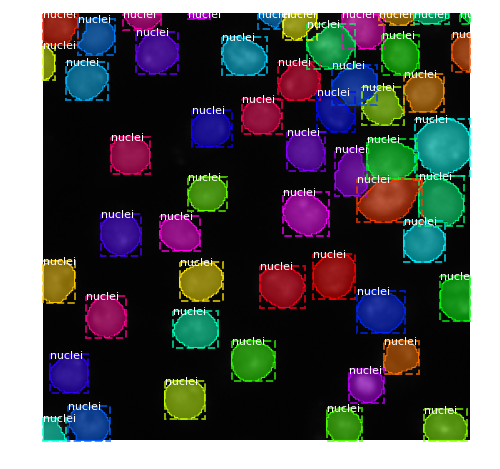

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    2.00000  max:  135.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -121.70000  max:   31.10000
image_metas              shape: (1, 10)               min:    0.00000  max: 1024.00000


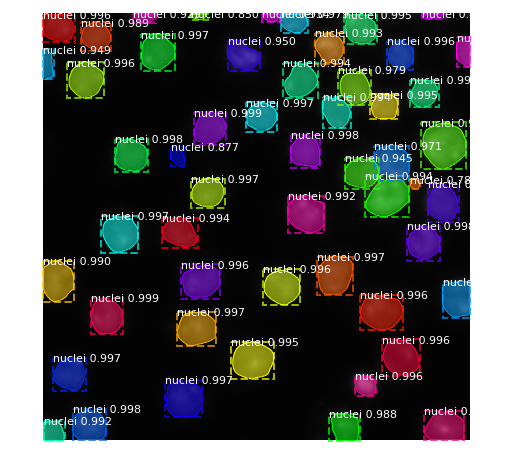

In [26]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)
print(dataset_val.image_info[image_id])
log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

results = model.detect([original_image], verbose=1)

r = results[0]
#print(r)
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

##Export Results for Submission


In [78]:
# Load test dataset
dataset_test = NucleiDataset()
dataset_test.load_nuclei(TEST_PATH, test_ids)
dataset_test.prepare()
print(len(dataset_test.image_ids))

65


In [60]:
# Test RLE encoding functions on train set masks
mask_test, _ = dataset_train.load_mask(0)

print(mask_test.shape)
print(pd.Series(mask_encode(mask_test)).apply(lambda x: ' '.join(str(y) for y in x)))


(256, 256, 16)
0     54029 16 54283 20 54539 21 54794 23 55049 25 5...
1     62016 5 62270 10 62524 15 62780 16 63035 17 63...
2     41286 5 41538 16 41794 17 42049 19 42305 19 42...
3     3834 7 4088 9 4342 11 4597 12 4852 13 5107 14 ...
4     13334 3 13587 9 13841 13 14095 16 14349 18 146...
5     22037 5 22292 10 22548 11 22804 11 23060 11 23...
6     60320 6 60574 10 60825 17 61080 20 61335 23 61...
7     55425 9 55679 11 55934 13 56189 15 56445 18 56...
8     46613 7 46866 12 47119 16 47373 18 47628 19 47...
9                         1 10 257 9 513 8 769 7 1025 4
10          64389 7 64642 11 64897 13 65153 16 65408 19
11    59137 1 59393 2 59649 6 59905 8 60161 9 60417 ...
12    43628 9 43882 13 44136 16 44391 19 44646 21 44...
13    49193 4 49445 9 49700 11 49955 12 50211 13 504...
14    59069 8 59322 14 59577 16 59832 19 60088 19 60...
15      50252 6 50507 8 50763 8 51019 8 51276 7 51533 5
dtype: object


Processing 1 images
image                    shape: (524, 348, 3)         min:    0.00000  max:  253.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  145.10000
image_metas              shape: (1, 10)               min:    0.00000  max: 1024.00000


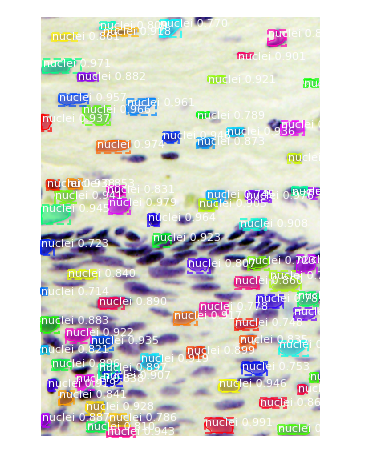

In [62]:
# Pick a test image to visualize
image = dataset_test.load_image(33)

# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_test.class_names, r['scores'], ax=get_ax())

print(r['masks'].shape)

In [82]:
# Run detection on all test and do RLE encoding

new_test_ids = []
rles = []
for image_id in dataset_val.image_ids:
    print('Processing: ' + val_index[image_id])
    try:    
        image = dataset_val.load_image(image_id)
        results = model.detect([image], verbose=0)
        r = results[0]
z
        ## Save plot to "./plot" (without overlapping mask correction
        plot_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax(), title=test_ids[image_id])
    
        rle = mask_encode(remove_overlap(r['masks']))
        rles = np.append(rles, rle)
        new_test_ids.extend([val_index[image_id]] * len(rle))
    except:
        continue
print(len(rles))
print(len(new_test_ids))

Processing: 519dc0d672d1c295fc69b629af8721ccb1a1f136d1976685a68487e62547ffe0


Processing: 44afae184c89e6ba55985b4d341acc1ae1e8b6ef96312064e0e6e630e022b078


Processing: 5cee644e5ffbef1ba021c7f389b33bafd3b1841f04d3edd7922d5084c2c4e0c7


Overlapping mask detected!
Overlapping mask detected!
Processing: ade080c6618cbbb0a25680cf847f312b5e19b22bfe1cafec0436987ebe5b1e7e


Overlapping mask detected!
Overlapping mask detected!
Overlapping mask detected!


Processing: 17b9bf4356db24967c4677b8376ac38f826de73a88b93a8d73a8b452e399cdff


Overlapping mask detected!
Processing: a984e7fb886aa02e29d112766d3ce26a4f78eac540ce7bbdbd42af2761928f6d


Processing: ca20076870e8fb604e61802605a9ac45419c82dd3e23404c56c4869f9502a5ef


Processing: 0114f484a16c152baa2d82fdd43740880a762c93f436c8988ac461c5c9dbe7d5


In [81]:
# Save results for submission

import pandas as pd

# Create submission DataFramevim
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('./submit/sub-dsbowl2018-6.csv', index=False)